In [80]:
%matplotlib inline

import numpy as np

from matplotlib import rc
import matplotlib.pyplot as plt
import scipy.stats as st

import sys
# sys.path.append("/home/ubuntu/catkin_ws/src/linefollow_gazebo/scripts")
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts/")

import helper as h
from CameraModel import Camera
from RoadModel import Road, NormalProbabilityDist
from Path import Path

In [81]:
def get_predicted_error_radius(camera_height,
                               ground_distance, 
                               pixel_area,
                               sigma_pos=0.03/2.0,
                               sigma_orient_deg=0.5/2,
                               alg_error=4.0, # note: changed
                               verbose=False,
                               orientation_percent=0.9,
                               pos_percent=0.9,
                               alg_percent=0.9,
                               use_err_xy=True,
                               use_err_z=True,
                               use_err_orient=True,
                               use_err_pixel=True
                              ):
    # TODO this is wrong implementation! Doesn't matter though really as long as use is consistent
    # but really it should be -1*norm.ppf((1-percent)/2.0)
    # as it is is an underestimate

    stddevs_orientation = st.norm.ppf(orientation_percent)
    stddevs_position = st.norm.ppf(pos_percent)
    stddevs_alg = st.norm.ppf(alg_percent)
    
    
    # NOT invariant between pixels
    z_error = (ground_distance/camera_height)*stddevs_position*sigma_pos if use_err_z else 0
    
    # NOT invariant between pixels
    if use_err_orient:
        t = stddevs_orientation*np.deg2rad(sigma_orient_deg)
        alpha = np.arctan2(ground_distance, camera_height)
        beta = alpha + t
        if beta > np.pi/2: # causes tan to roll over into negatives...
            orientation_error = 9999999999
        else:
            orientation_error = np.tan(beta)*camera_height - ground_distance
    else:
        orientation_error = 0
    
    pixel_error = np.sqrt(2*pixel_area) if use_err_pixel else 0
    
#     print("Z error: {0}".format(z_error))
#     print("orien error: {0}".format(orientation_error))
#     print("pixel_error: {0}".format(pixel_error))
    total = z_error + orientation_error + (alg_error+1)/2.0 * stddevs_alg * pixel_error
    return total, z_error, orientation_error, alg_error*pixel_error

In [82]:
def error_radius_across_pixels(camera):
    
    image = np.zeros(shape=(camera.R_y, camera.R_x+1)) # add one because using pixel as bottom left corner! Symmetry matters here
    camera_x, camera_y, camera_z = camera.position
    camera_ground_pos = np.array([camera_x, camera_y, 0.0])

    for (y,x), _ in np.ndenumerate(image):

        ground_point = camera.pixel_to_plane(x, y)
        pixel_area = camera.plane_area_of_pixel(x,y)

        if ground_point is None or pixel_area is None:
            image[y, x] = 999999999999
            continue

        ground_distance = np.linalg.norm(ground_point - camera_ground_pos)

        image[y, x] = get_predicted_error_radius(camera_z, ground_distance, pixel_area)[0]

        return image
        

In [83]:
# basically follows the pseudocode from wikipedia for continuous hillclimbing

def hillclimb(score_function, parameter_ranges, parameter_initializations=None, finish_epsilon=0.1, parameter_step_fraction=0.05, acceleration=1.2):
    """ Takes a scoring function, a set of parameter ranges, parameter initializations if desired, the finishing epsilon, and the fraction of the parameter range that one step takes initially    
    """
    
    params = []
    # if no initializations, choose one randomly
    if parameter_initializations is None:
        for param_range in parameter_ranges:
            params.append(np.random.uniform(*param_range))
    else:
        params = parameter_initializations
    params = np.array(params)
    
    params_ranges = np.array([upper - lower for (lower, upper) in parameter_ranges])
    params_step = params_ranges * parameter_step_fraction
    
    movements = np.array([-acceleration, -1.0/acceleration, 0, 1.0/acceleration, acceleration])
    
    
    score = score_function(params)
    while True:
        
        for i, param in enumerate(params):
            
            best_move = -1
            best_score = -9999999
            
            # do 5 steps per param
            # this is relatively inefficient with an expensive cost function
            # since we evaluate '0' parameter each time, which doesn't need to be evaluated...
            for j, move in enumerate(movements):
                params[i] += params_step[i] * move
                
                # check if move is out of bounds!
                if params[i] < parameter_ranges[i][0] or params[i] > parameter_ranges[i][1]:
                    # then skip, can always revert to '0' or no change
                    params[i] -= params_step[i] * move
                    continue
                
                new_score = score_function(params)
                params[i] -= params_step[i] * move
                
                if new_score > best_score:
                    best_score = new_score
                    best_move = j
            
            if movements[best_move] == 0:
                params_step[i] /= acceleration
            else:
                params[i] += params_step[i] * movements[best_move]
                params_step[i] = params_step[i] * movements[best_move] # accelerate step size
           
        updated_score = score_function(params)
        if updated_score - score < finish_epsilon:
            return (score, params)
        score = updated_score
            


In [84]:
# Hill climbing with random restarts

def random_restart_hillclimb(score_function, parameter_ranges, finish_epsilon=0.1, parameter_step_fraction=0.01, acceleration=1.2, num_restarts=100, initialization_generator=None, append_to=None):
    
    if append_to is None:
        local_score_maxima = []
        local_maxima_params = []
    else:
        local_score_maxima = append_to[0]
        local_maxima_params = append_to[1]
    
    for _ in range(num_restarts):
        if initialization_generator is not None:
            init_params = initialization_generator(parameter_ranges)
        else:
            init_params = None
        
        try:
            score, params = hillclimb(score_function, parameter_ranges, parameter_initializations=init_params, finish_epsilon=finish_epsilon, parameter_step_fraction=parameter_step_fraction, acceleration=acceleration)
            print("{0}, params: {1}".format(score, params))

        except Exception as e: # something...
            print("error!", e)
        
        local_score_maxima.append(score)
        local_maxima_params.append(params)
    return (local_score_maxima, local_maxima_params)
        

In [85]:
road_prob_dist = NormalProbabilityDist(two_stddev=0.4)

camera_height = 6.0
resolution = (100, 100)
yaw_range = 90 # degrees +- from center yaw position

curvature = 0.0
length = 40.0 # does matter! can see end of road!

path = Path()
path.add_segment(curvature, length)
road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

# place camera halfway along road
allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
lhs_pos, lhs_direction = allowed_positions_orientations[0]
rhs_pos, rhs_direction = allowed_positions_orientations[1]

# just stick with lhs for now, symmetric with straight road

camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
camera_pitch_range = np.array([31.0, 85.0])

# convert lhs_direction into a yaw facing the road perpendicularly
center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
center_yaw_deg = np.rad2deg(center_yaw_rad)
camera_yaw_range = np.array([center_yaw_deg - yaw_range, center_yaw_deg + yaw_range])

fov_h_range = np.array([20.0, 120.0])
fov_v_range = fov_h_range.copy()


In [8]:
print(camera_position)
print(center_yaw_deg)


[ 20.  -3.   6.]
90.0


In [9]:
def score_function(params):
    pitch, yaw, h_fov, v_fov = params
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(*resolution)
    c.set_fov(h_fov, v_fov)
    
    
    error_bounds = error_radius_across_pixels(c)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    
    target = (1/(1+(error_bounds/3.0)**2)) * pixel_probabilities
    score = np.sum(target)
    print("--score, params: {0}, {1}".format(score, params))
    return score
    

In [9]:
scores_params = [[],[]]

In [10]:
param_ranges = np.array([
    camera_pitch_range, camera_yaw_range, fov_h_range, fov_v_range
])


random_restart_hillclimb(score_function, param_ranges, finish_epsilon=0.1, parameter_step_fraction=0.1, acceleration=1.5, num_restarts=100, append_to=scores_params)

--score, params: 1.11806536012, [  47.70754652  130.93235042  118.45720813   22.88764973]
--score, params: 0.964181101583, [  39.60754652  130.93235042  118.45720813   22.88764973]
--score, params: 1.05225359554, [  44.10754652  130.93235042  118.45720813   22.88764973]
--score, params: 1.11806536012, [  47.70754652  130.93235042  118.45720813   22.88764973]
--score, params: 1.17945839844, [  51.30754652  130.93235042  118.45720813   22.88764973]
--score, params: 1.24964221087, [  55.80754652  130.93235042  118.45720813   22.88764973]
--score, params: 3.40002077021, [  55.80754652  103.93235042  118.45720813   22.88764973]
--score, params: 1.69235433492, [  55.80754652  118.93235042  118.45720813   22.88764973]
--score, params: 1.24964221087, [  55.80754652  130.93235042  118.45720813   22.88764973]
--score, params: 1.02606340934, [  55.80754652  142.93235042  118.45720813   22.88764973]
--score, params: 0.883449683828, [  55.80754652  157.93235042  118.45720813   22.88764973]
--score,

--score, params: 3.09067977732, [  70.65547409  109.68270669   79.29855437   49.33556693]
--score, params: 3.02646990498, [  62.55547409  109.68270669   79.29855437   49.33556693]
--score, params: 3.04908514814, [  67.05547409  109.68270669   79.29855437   49.33556693]
--score, params: 3.09067977732, [  70.65547409  109.68270669   79.29855437   49.33556693]
--score, params: 2.98499798426, [  74.25547409  109.68270669   79.29855437   49.33556693]
--score, params: 2.60439846559, [  78.75547409  109.68270669   79.29855437   49.33556693]
--score, params: 2.51638569422, [  70.65547409  136.68270669   79.29855437   49.33556693]
--score, params: 2.69751863311, [  70.65547409  121.68270669   79.29855437   49.33556693]
--score, params: 3.09067977732, [  70.65547409  109.68270669   79.29855437   49.33556693]
--score, params: 2.9870779096, [ 70.65547409  97.68270669  79.29855437  49.33556693]
--score, params: 2.98532342268, [ 70.65547409  82.68270669  79.29855437  49.33556693]
--score, params: 2.

--score, params: 2.60368816555, [ 48.46937087  36.98870548  61.8987449   43.78342311]
--score, params: 2.60368816555, [ 48.46937087  36.98870548  61.8987449   43.78342311]
--score, params: 1.95925384747, [ 36.31937087  36.98870548  61.8987449   43.78342311]
--score, params: 2.37686682492, [ 43.06937087  36.98870548  61.8987449   43.78342311]
--score, params: 2.60368816555, [ 48.46937087  36.98870548  61.8987449   43.78342311]
--score, params: 2.80738447104, [ 53.86937087  36.98870548  61.8987449   43.78342311]
--score, params: 3.00534557928, [ 60.61937087  36.98870548  61.8987449   43.78342311]
--score, params: 2.55596733235, [ 60.61937087  18.98870548  61.8987449   43.78342311]
--score, params: 3.00534557928, [ 60.61937087  36.98870548  61.8987449   43.78342311]
--score, params: 3.68143993697, [ 60.61937087  54.98870548  61.8987449   43.78342311]
--score, params: 3.39335491615, [ 60.61937087  77.48870548  61.8987449   43.78342311]
--score, params: 2.7867592591, [ 60.61937087  54.98870

--score, params: 1.13467583851, [  31.62003324   61.78342327   41.91747094  117.78306129]
--score, params: 1.95455395912, [ 31.62003324  61.78342327  41.91747094  87.78306129]
--score, params: 1.63305447977, [ 43.77003324  61.78342327  41.91747094  87.78306129]
--score, params: 1.78084808096, [ 37.02003324  61.78342327  41.91747094  87.78306129]
--score, params: 1.95455395912, [ 31.62003324  61.78342327  41.91747094  87.78306129]
--score, params: 1.93918503098, [ 31.62003324  79.78342327  41.91747094  87.78306129]
--score, params: 1.9472354659, [ 31.62003324  69.78342327  41.91747094  87.78306129]
--score, params: 1.95455395912, [ 31.62003324  61.78342327  41.91747094  87.78306129]
--score, params: 1.95835048495, [ 31.62003324  53.78342327  41.91747094  87.78306129]
--score, params: 1.94690173198, [ 31.62003324  43.78342327  41.91747094  87.78306129]
--score, params: 1.95835553297, [ 31.62003324  53.78342327  31.91747094  87.78306129]
--score, params: 1.9583555703, [ 31.62003324  53.78

--score, params: 3.69620169749, [ 35.62003324  36.89453438  20.80635983  44.44972795]
--score, params: 3.94301575391, [ 37.22003324  36.89453438  20.80635983  44.44972795]
--score, params: 4.10490347678, [ 39.22003324  36.89453438  20.80635983  44.44972795]
--score, params: 3.89117410539, [ 39.22003324  42.22786771  20.80635983  44.44972795]
--score, params: 4.028755524, [ 39.22003324  39.26490475  20.80635983  44.44972795]
--score, params: 4.10490347678, [ 39.22003324  36.89453438  20.80635983  44.44972795]
--score, params: 4.14906312107, [ 39.22003324  34.52416401  20.80635983  44.44972795]
--score, params: 4.16294988136, [ 39.22003324  31.56120104  20.80635983  44.44972795]
--score, params: 3.98031721203, [ 39.22003324  31.56120104  27.47302649  44.44972795]
--score, params: 4.11883175159, [ 39.22003324  31.56120104  23.76932279  44.44972795]
--score, params: 4.16294988136, [ 39.22003324  31.56120104  20.80635983  44.44972795]
--score, params: 2.9903545405, [ 39.22003324  31.5612010

--score, params: 7.59219462175, [ 48.62003324  37.48712697  20.22108319  22.78306129]
--score, params: 7.65959126513, [ 48.62003324  35.51181833  21.09899815  22.78306129]
--score, params: 7.73672990386, [ 48.62003324  35.51181833  20.61126762  22.78306129]
--score, params: 7.79337482989, [ 48.62003324  35.51181833  20.22108319  22.78306129]
--score, params: 6.79445418842, [ 48.62003324  35.51181833  20.22108319  27.22750573]
--score, params: 7.36465300887, [ 48.62003324  35.51181833  20.22108319  24.75836993]
--score, params: 7.79337482989, [ 48.62003324  35.51181833  20.22108319  22.78306129]
--score, params: 8.1432295008, [ 48.62003324  35.51181833  20.22108319  20.80775265]
--score, params: 8.1432295008, [ 48.62003324  35.51181833  20.22108319  20.80775265]
--score, params: 7.70428665854, [ 47.02003324  35.51181833  20.22108319  20.80775265]
--score, params: 7.99042088533, [ 47.90892213  35.51181833  20.22108319  20.80775265]
--score, params: 8.1432295008, [ 48.62003324  35.5118183

--score, params: 1.27887107634, [  66.72830024  146.84125525  110.00857175   66.30778149]
--score, params: 1.12653945364, [  66.72830024  146.84125525  116.67523841   66.30778149]
--score, params: 1.48673055815, [  66.72830024  146.84125525  101.67523841   51.30778149]
--score, params: 1.4873216792, [  66.72830024  146.84125525  101.67523841   59.64111483]
--score, params: 1.48783294721, [  66.72830024  146.84125525  101.67523841   66.30778149]
--score, params: 1.48837653738, [  66.72830024  146.84125525  101.67523841   72.97444816]
--score, params: 1.48914398483, [  66.72830024  146.84125525  101.67523841   81.30778149]
--score, params: 1.48914398483, [  66.72830024  146.84125525  101.67523841   81.30778149]
--score, params: 1.28984125926, [  54.57830024  146.84125525  101.67523841   81.30778149]
--score, params: 1.42368531904, [  61.32830024  146.84125525  101.67523841   81.30778149]
--score, params: 1.48914398483, [  66.72830024  146.84125525  101.67523841   81.30778149]
--score, pa

--score, params: 5.30472534759, [ 67.47830024  65.84125525  45.42523841  27.14111483]
--score, params: 5.79617876189, [ 67.47830024  65.84125525  32.92523841  27.14111483]
--score, params: 5.9149817736, [ 67.47830024  65.84125525  22.92523841  27.14111483]
--score, params: 4.25792906317, [ 67.47830024  65.84125525  22.92523841  37.14111483]
--score, params: 5.05771712854, [ 67.47830024  65.84125525  22.92523841  31.58555927]
--score, params: 5.9149817736, [ 67.47830024  65.84125525  22.92523841  27.14111483]
--score, params: 6.84133176454, [ 67.47830024  65.84125525  22.92523841  22.69667038]
--score, params: 6.84133176454, [ 67.47830024  65.84125525  22.92523841  22.69667038]
--score, params: 4.83390028136, [ 71.07830024  65.84125525  22.92523841  22.69667038]
--score, params: 6.18229445707, [ 69.07830024  65.84125525  22.92523841  22.69667038]
--score, params: 6.84133176454, [ 67.47830024  65.84125525  22.92523841  22.69667038]
--score, params: 7.05175250049, [ 65.87830024  65.841255

--score, params: 8.45087075007, [ 58.07830024  47.84125525  20.94992977  20.13608511]
--score, params: 8.64508563908, [ 56.7449669   47.84125525  20.94992977  20.13608511]
--score, params: 8.63680893028, [ 55.67830024  47.84125525  20.94992977  20.13608511]
--score, params: 8.49926318734, [ 54.61163357  47.84125525  20.94992977  20.13608511]
--score, params: 8.13912281194, [ 53.27830024  47.84125525  20.94992977  20.13608511]
--score, params: 8.27348720526, [ 56.7449669   55.84125525  20.94992977  20.13608511]
--score, params: 8.51720579906, [ 56.7449669   51.39681081  20.94992977  20.13608511]
--score, params: 8.64508563908, [ 56.7449669   47.84125525  20.94992977  20.13608511]
--score, params: 8.31937468356, [ 56.7449669   44.2856997   20.94992977  20.13608511]
--score, params: 7.27515047241, [ 56.7449669   39.84125525  20.94992977  20.13608511]
--score, params: 8.51703812225, [ 56.7449669   47.84125525  22.92523841  20.13608511]
--score, params: 8.5964006542, [ 56.7449669   47.84125

--score, params: 3.10770918917, [ 50.54133194  72.05812975  75.71266774  49.28746   ]
--score, params: 2.71485922448, [ 50.54133194  72.05812975  75.71266774  55.95412667]
--score, params: 2.37107373049, [ 50.54133194  72.05812975  75.71266774  62.62079334]
--score, params: 2.02363786799, [ 50.54133194  72.05812975  75.71266774  70.95412667]
--score, params: 3.27147775155, [ 50.54133194  72.05812975  75.71266774  40.95412667]
--score, params: 1.40937322379, [ 38.39133194  72.05812975  75.71266774  40.95412667]
--score, params: 2.44492860051, [ 45.14133194  72.05812975  75.71266774  40.95412667]
--score, params: 3.27147775155, [ 50.54133194  72.05812975  75.71266774  40.95412667]
--score, params: 3.72972191715, [ 55.94133194  72.05812975  75.71266774  40.95412667]
--score, params: 3.70033148105, [ 62.69133194  72.05812975  75.71266774  40.95412667]
--score, params: 3.02207444628, [ 55.94133194  54.05812975  75.71266774  40.95412667]
--score, params: 3.52084279203, [ 55.94133194  64.0581

--score, params: 2.01180424458, [  31.09434766  118.85269004   58.73223633   86.58315621]
--score, params: 2.00078493836, [  31.09434766  118.85269004   63.17668078   86.58315621]
--score, params: 1.96545341323, [  31.09434766  118.85269004   68.73223633   86.58315621]
--score, params: 1.35326869144, [  31.09434766  118.85269004   48.73223633  109.08315621]
--score, params: 1.69345511732, [  31.09434766  118.85269004   48.73223633   96.58315621]
--score, params: 2.01675781374, [  31.09434766  118.85269004   48.73223633   86.58315621]
--score, params: 2.25649116375, [  31.09434766  118.85269004   48.73223633   76.58315621]
--score, params: 1.80137151977, [  31.09434766  118.85269004   48.73223633   64.08315621]
--score, params: 2.25649116375, [  31.09434766  118.85269004   48.73223633   76.58315621]
--score, params: 2.24878626371, [  34.69434766  118.85269004   48.73223633   76.58315621]
--score, params: 2.28927002033, [  32.69434766  118.85269004   48.73223633   76.58315621]
--score, p

--score, params: 5.14257289572, [ 46.01744125  27.55362681  24.11691563  35.06615146]
--score, params: 4.04611263955, [ 46.01744125  20.88696015  24.11691563  35.06615146]
--score, params: 5.29950063755, [ 46.01744125  32.88696015  21.15395267  35.06615146]
--score, params: 5.2706073521, [ 46.01744125  32.88696015  24.11691563  35.06615146]
--score, params: 5.18806001623, [ 46.01744125  32.88696015  27.0798786   35.06615146]
--score, params: 4.96378111045, [ 46.01744125  32.88696015  30.7835823   35.06615146]
--score, params: 3.59047463269, [ 46.01744125  32.88696015  21.15395267  50.06615146]
--score, params: 4.3987283557, [ 46.01744125  32.88696015  21.15395267  41.73281812]
--score, params: 5.29950063755, [ 46.01744125  32.88696015  21.15395267  35.06615146]
--score, params: 6.44847933602, [ 46.01744125  32.88696015  21.15395267  28.39948479]
--score, params: 7.52042305039, [ 46.01744125  32.88696015  21.15395267  20.06615146]
--score, params: 7.52042305039, [ 46.01744125  32.886960

--score, params: 8.62234557929, [ 51.61744125  39.77859252  20.27603772  20.06615146]
--score, params: 8.62234557929, [ 51.61744125  39.77859252  20.27603772  20.06615146]
8.61403170034, params: [ 51.61744125  39.77859252  20.27603772  20.06615146]
--score, params: 2.16704588655, [  65.75441822  124.31714214   78.55514502   69.68440643]
--score, params: 2.13711869223, [  57.65441822  124.31714214   78.55514502   69.68440643]
--score, params: 2.14302617336, [  62.15441822  124.31714214   78.55514502   69.68440643]
--score, params: 2.16704588655, [  65.75441822  124.31714214   78.55514502   69.68440643]
--score, params: 2.2010840386, [  69.35441822  124.31714214   78.55514502   69.68440643]
--score, params: 2.13465729526, [  73.85441822  124.31714214   78.55514502   69.68440643]
--score, params: 1.95910630544, [ 69.35441822  97.31714214  78.55514502  69.68440643]
--score, params: 2.05300175999, [  69.35441822  112.31714214   78.55514502   69.68440643]
--score, params: 2.2010840386, [  69

--score, params: 6.46407579541, [  62.15441822  122.53936436   41.05514502   22.18440643]
--score, params: 7.06681452156, [  62.15441822  122.53936436   32.72181169   22.18440643]
--score, params: 7.41098662198, [  62.15441822  122.53936436   26.05514502   22.18440643]
--score, params: 4.38773112919, [  62.15441822  122.53936436   26.05514502   37.18440643]
--score, params: 5.7376921051, [  62.15441822  122.53936436   26.05514502   28.85107309]
--score, params: 7.41098662198, [  62.15441822  122.53936436   26.05514502   22.18440643]
--score, params: 7.41098662198, [  62.15441822  122.53936436   26.05514502   22.18440643]
--score, params: 5.40606929556, [  67.55441822  122.53936436   26.05514502   22.18440643]
--score, params: 6.78885562752, [  64.55441822  122.53936436   26.05514502   22.18440643]
--score, params: 7.41098662198, [  62.15441822  122.53936436   26.05514502   22.18440643]
--score, params: 7.50531295382, [  59.75441822  122.53936436   26.05514502   22.18440643]
--score, pa

--score, params: 2.02992957317, [  58.19850165  146.50378408   79.30615751   72.49621263]
--score, params: 2.80589099182, [  58.19850165  146.50378408   49.30615751   57.49621263]
--score, params: 2.5540912522, [  58.19850165  146.50378408   49.30615751   65.82954597]
--score, params: 2.35236493628, [  58.19850165  146.50378408   49.30615751   72.49621263]
--score, params: 2.0894164165, [  58.19850165  146.50378408   49.30615751   79.1628793 ]
--score, params: 1.80455983929, [  58.19850165  146.50378408   49.30615751   87.49621263]
--score, params: 2.80589099182, [  58.19850165  146.50378408   49.30615751   57.49621263]
--score, params: 2.97055297235, [  46.04850165  146.50378408   49.30615751   57.49621263]
--score, params: 2.95663652345, [  52.79850165  146.50378408   49.30615751   57.49621263]
--score, params: 2.80589099182, [  58.19850165  146.50378408   49.30615751   57.49621263]
--score, params: 2.63726818762, [  63.59850165  146.50378408   49.30615751   57.49621263]
--score, par

--score, params: 3.06378780871, [ 39.31269545  92.99722078  40.01140436  53.56150822]
--score, params: 2.91944831272, [ 39.31269545  99.66388745  40.01140436  53.56150822]
--score, params: 3.02245512097, [ 39.31269545  87.66388745  73.76140436  53.56150822]
--score, params: 3.05545931185, [ 39.31269545  87.66388745  55.01140436  53.56150822]
--score, params: 3.07103805452, [ 39.31269545  87.66388745  40.01140436  53.56150822]
--score, params: 3.08036785204, [ 39.31269545  87.66388745  25.01140436  53.56150822]
--score, params: 2.78194993913, [ 39.31269545  87.66388745  25.01140436  60.22817489]
--score, params: 2.99139754832, [ 39.31269545  87.66388745  25.01140436  56.52447119]
--score, params: 3.08036785204, [ 39.31269545  87.66388745  25.01140436  53.56150822]
--score, params: 2.74716849666, [ 39.31269545  87.66388745  25.01140436  50.59854526]
--score, params: 1.36253868342, [ 39.31269545  87.66388745  25.01140436  46.89484156]
--score, params: 3.08036785204, [ 39.31269545  87.6638

--score, params: 4.48317719301, [  48.91255796  136.81989726   21.87350788   39.55989994]
--score, params: 3.40356353795, [  44.41255796  109.81989726   21.87350788   39.55989994]
--score, params: 4.01063583752, [  44.41255796  124.81989726   21.87350788   39.55989994]
--score, params: 4.48483954571, [  44.41255796  136.81989726   21.87350788   39.55989994]
--score, params: 4.67598502211, [  44.41255796  148.81989726   21.87350788   39.55989994]
--score, params: 3.15888203624, [  44.41255796  163.81989726   21.87350788   39.55989994]
--score, params: 2.58358866489, [  44.41255796  148.81989726   55.62350788   39.55989994]
--score, params: 4.06884858308, [  44.41255796  148.81989726   36.87350788   39.55989994]
--score, params: 4.67598502211, [  44.41255796  148.81989726   21.87350788   39.55989994]
--score, params: 2.26082331432, [  44.41255796  148.81989726   21.87350788   73.30989994]
--score, params: 3.26239515561, [  44.41255796  148.81989726   21.87350788   54.55989994]
--score, p

--score, params: 2.2780808299, [ 83.89146554  11.60304711  73.00675438  65.98925538]
--score, params: 2.02120002613, [ 83.89146554  11.60304711  79.67342105  65.98925538]
--score, params: 2.15940424004, [ 83.89146554  11.60304711  75.96971734  65.98925538]
--score, params: 2.2780808299, [ 83.89146554  11.60304711  73.00675438  65.98925538]
--score, params: 2.39772731103, [ 83.89146554  11.60304711  70.04379142  65.98925538]
--score, params: 2.48383089866, [ 83.89146554  11.60304711  66.34008771  65.98925538]
--score, params: 1.9592994679, [ 83.89146554  11.60304711  66.34008771  99.73925538]
--score, params: 2.26828937682, [ 83.89146554  11.60304711  66.34008771  80.98925538]
--score, params: 2.48383089866, [ 83.89146554  11.60304711  66.34008771  65.98925538]
--score, params: 2.56596417763, [ 83.89146554  11.60304711  66.34008771  50.98925538]
--score, params: 2.5783610284, [ 83.89146554  11.60304711  66.34008771  32.23925538]
--score, params: 2.5783610284, [ 83.89146554  11.60304711 

--score, params: 4.11693937503, [  42.54634605  141.11754645   28.62677909   38.58640057]
--score, params: 4.64034506559, [  42.54634605  153.11754645   28.62677909   38.58640057]
--score, params: 3.17690437141, [  42.54634605  165.11754645   28.62677909   38.58640057]
--score, params: 3.15627355499, [  42.54634605  153.11754645   43.62677909   38.58640057]
--score, params: 3.95879234623, [  42.54634605  153.11754645   35.29344576   38.58640057]
--score, params: 4.64034506559, [  42.54634605  153.11754645   28.62677909   38.58640057]
--score, params: 4.78138660234, [  42.54634605  153.11754645   21.96011242   38.58640057]
--score, params: 2.29116407505, [  42.54634605  153.11754645   21.96011242   72.33640057]
--score, params: 3.31676905018, [  42.54634605  153.11754645   21.96011242   53.58640057]
--score, params: 4.78138660234, [  42.54634605  153.11754645   21.96011242   38.58640057]
--score, params: 6.43989814386, [  42.54634605  153.11754645   21.96011242   23.58640057]
--score, p

--score, params: 3.24739411757, [  74.98727399  105.35200968   35.7994045    47.7315781 ]
--score, params: 3.33655626853, [ 80.38727399  97.35200968  35.7994045   47.7315781 ]
--score, params: 3.36881248234, [  80.38727399  101.79645413   35.7994045    47.7315781 ]
--score, params: 3.38038986868, [  80.38727399  105.35200968   35.7994045    47.7315781 ]
--score, params: 3.31257371831, [  80.38727399  108.90756524   35.7994045    47.7315781 ]
--score, params: 3.05463567191, [  80.38727399  113.35200968   35.7994045    47.7315781 ]
--score, params: 3.07248058415, [  80.38727399  105.35200968   58.2994045    47.7315781 ]
--score, params: 3.29289617024, [  80.38727399  105.35200968   45.7994045    47.7315781 ]
--score, params: 3.38038986868, [  80.38727399  105.35200968   35.7994045    47.7315781 ]
--score, params: 3.40916677737, [  80.38727399  105.35200968   25.7994045    47.7315781 ]
--score, params: 2.74203913826, [  80.38727399  105.35200968   25.7994045    57.7315781 ]
--score, param

--score, params: 5.1621871855, [  73.72060732  105.35200968   21.35496006   28.47231884]
--score, params: 2.29296744231, [  77.32060732  105.35200968   21.35496006   28.47231884]
--score, params: 4.17446092899, [  75.32060732  105.35200968   21.35496006   28.47231884]
--score, params: 5.1621871855, [  73.72060732  105.35200968   21.35496006   28.47231884]
--score, params: 5.49078809637, [  72.12060732  105.35200968   21.35496006   28.47231884]
--score, params: 5.49570232594, [  70.12060732  105.35200968   21.35496006   28.47231884]
--score, params: 5.45748946619, [  70.12060732  102.98163931   21.35496006   28.47231884]
--score, params: 5.47804425476, [  70.12060732  104.29851174   21.35496006   28.47231884]
--score, params: 5.49570232594, [  70.12060732  105.35200968   21.35496006   28.47231884]
--score, params: 5.51418538274, [  70.12060732  106.40550762   21.35496006   28.47231884]
--score, params: 5.53777460042, [  70.12060732  107.72238005   21.35496006   28.47231884]
--score, par

--score, params: 3.04654179115, [ 76.54079736  77.94065447  40.26024813  27.77147181]
--score, params: 5.18841142109, [ 72.94079736  77.94065447  40.26024813  27.77147181]
--score, params: 5.56676806771, [ 69.34079736  77.94065447  40.26024813  27.77147181]
--score, params: 5.50688783621, [ 64.84079736  77.94065447  40.26024813  27.77147181]
--score, params: 1.9226609865, [ 69.34079736  17.19065447  40.26024813  27.77147181]
--score, params: 3.78289098697, [ 69.34079736  50.94065447  40.26024813  27.77147181]
--score, params: 5.56676806771, [ 69.34079736  77.94065447  40.26024813  27.77147181]
--score, params: 5.59214971352, [  69.34079736  104.94065447   40.26024813   27.77147181]
--score, params: 3.30016355202, [  69.34079736  138.69065447   40.26024813   27.77147181]
--score, params: 4.82891006634, [  69.34079736  104.94065447   74.01024813   27.77147181]
--score, params: 5.41054275164, [  69.34079736  104.94065447   55.26024813   27.77147181]
--score, params: 5.59214971352, [  69.3

--score, params: 3.45780493475, [ 75.6516305   53.51637523  70.92471072  20.71792446]
--score, params: 3.61299143495, [ 74.0516305   53.51637523  70.92471072  20.71792446]
--score, params: 3.69264196773, [ 72.0516305   53.51637523  70.92471072  20.71792446]
--score, params: 2.9627217148, [ 72.0516305   41.51637523  70.92471072  20.71792446]
--score, params: 3.32550885852, [ 72.0516305   48.1830419   70.92471072  20.71792446]
--score, params: 3.69264196773, [ 72.0516305   53.51637523  70.92471072  20.71792446]
--score, params: 3.97820189381, [ 72.0516305   58.84970856  70.92471072  20.71792446]
--score, params: 4.07793300202, [ 72.0516305   65.51637523  70.92471072  20.71792446]
--score, params: 4.03637000336, [ 72.0516305   65.51637523  64.25804405  20.71792446]
--score, params: 4.0599452519, [ 72.0516305   65.51637523  67.96174776  20.71792446]
--score, params: 4.07793300202, [ 72.0516305   65.51637523  70.92471072  20.71792446]
--score, params: 4.09373544149, [ 72.0516305   65.516375

--score, params: 4.92275346576, [  52.42922339  146.41082397   32.02975997   32.75458319]
--score, params: 4.68225813004, [  44.32922339  146.41082397   32.02975997   32.75458319]
--score, params: 5.11072269053, [  48.82922339  146.41082397   32.02975997   32.75458319]
--score, params: 4.92275346576, [  52.42922339  146.41082397   32.02975997   32.75458319]
--score, params: 4.50334410189, [  56.02922339  146.41082397   32.02975997   32.75458319]
--score, params: 3.90286978292, [  60.52922339  146.41082397   32.02975997   32.75458319]
--score, params: 1.69988830665, [  48.82922339  173.41082397   32.02975997   32.75458319]
--score, params: 3.98118604703, [  48.82922339  158.41082397   32.02975997   32.75458319]
--score, params: 5.11072269053, [  48.82922339  146.41082397   32.02975997   32.75458319]
--score, params: 4.77487635169, [  48.82922339  134.41082397   32.02975997   32.75458319]
--score, params: 4.16852109376, [  48.82922339  119.41082397   32.02975997   32.75458319]
--score, p

--score, params: 2.07075523318, [  80.46853428   23.21032921   26.27815559  102.60383155]
--score, params: 1.90775057609, [  72.36853428   23.21032921   26.27815559  102.60383155]
--score, params: 2.10429039493, [  76.86853428   23.21032921   26.27815559  102.60383155]
--score, params: 2.07075523318, [  80.46853428   23.21032921   26.27815559  102.60383155]
--score, params: 1.94731054998, [  84.06853428   23.21032921   26.27815559  102.60383155]
--score, params: 1.38960831883, [  76.86853428   50.21032921   26.27815559  102.60383155]
--score, params: 1.69984996559, [  76.86853428   35.21032921   26.27815559  102.60383155]
--score, params: 2.10429039493, [  76.86853428   23.21032921   26.27815559  102.60383155]
--score, params: 1.18536427987, [  76.86853428   11.21032921   26.27815559  102.60383155]
--score, params: 1.64355382085, [  76.86853428   23.21032921   60.02815559  102.60383155]
--score, params: 1.8034981172, [  76.86853428   23.21032921   41.27815559  102.60383155]
--score, pa

--score, params: 1.36009509014, [ 82.83388305  89.72493563  72.90952392  95.89708601]
--score, params: 1.25860945912, [ 74.73388305  89.72493563  72.90952392  95.89708601]
--score, params: 1.30688787903, [ 79.23388305  89.72493563  72.90952392  95.89708601]
--score, params: 1.36009509014, [ 82.83388305  89.72493563  72.90952392  95.89708601]
--score, params: 1.50772285567, [ 82.83388305  62.72493563  72.90952392  95.89708601]
--score, params: 1.38795675629, [ 82.83388305  77.72493563  72.90952392  95.89708601]
--score, params: 1.36009509014, [ 82.83388305  89.72493563  72.90952392  95.89708601]
--score, params: 1.38546743316, [  82.83388305  101.72493563   72.90952392   95.89708601]
--score, params: 1.50133246586, [  82.83388305  116.72493563   72.90952392   95.89708601]
--score, params: 1.50772264104, [ 82.83388305  62.72493563  57.90952392  95.89708601]
--score, params: 1.50772335327, [ 82.83388305  62.72493563  66.24285725  95.89708601]
--score, params: 1.50772285567, [ 82.83388305 

--score, params: 2.81523735409, [ 80.43388305  62.72493563  30.13174614  59.7859749 ]
--score, params: 2.98178661124, [ 80.43388305  62.72493563  30.13174614  56.82301194]
--score, params: 3.11731668917, [ 80.43388305  62.72493563  30.13174614  53.11930824]
--score, params: 3.11731668917, [ 80.43388305  62.72493563  30.13174614  53.11930824]
--score, params: 2.76832541713, [ 82.83388305  62.72493563  30.13174614  53.11930824]
--score, params: 3.00299178764, [ 81.50054972  62.72493563  30.13174614  53.11930824]
--score, params: 3.11731668917, [ 80.43388305  62.72493563  30.13174614  53.11930824]
--score, params: 3.15859515794, [ 79.36721639  62.72493563  30.13174614  53.11930824]
--score, params: 3.14330883064, [ 78.03388305  62.72493563  30.13174614  53.11930824]
--score, params: 3.0433825334, [ 79.36721639  70.72493563  30.13174614  53.11930824]
--score, params: 3.11701210833, [ 79.36721639  66.28049119  30.13174614  53.11930824]
--score, params: 3.15859515794, [ 79.36721639  62.72493

--score, params: 4.09859975905, [ 73.58943861  60.09119077  20.13174614  40.77362922]
--score, params: 4.23721740758, [ 73.58943861  60.09119077  20.13174614  38.79832058]
--score, params: 4.28082806734, [ 73.58943861  60.09119077  20.13174614  36.32918478]
--score, params: 4.28082806734, [ 73.58943861  60.09119077  20.13174614  36.32918478]
--score, params: 2.86990584729, [ 77.18943861  60.09119077  20.13174614  36.32918478]
--score, params: 3.74722436664, [ 75.18943861  60.09119077  20.13174614  36.32918478]
--score, params: 4.28082806734, [ 73.58943861  60.09119077  20.13174614  36.32918478]
--score, params: 4.53342258788, [ 71.98943861  60.09119077  20.13174614  36.32918478]
--score, params: 4.55765492509, [ 69.98943861  60.09119077  20.13174614  36.32918478]
--score, params: 4.49392777578, [ 69.98943861  62.46156115  20.13174614  36.32918478]
--score, params: 4.52931633767, [ 69.98943861  61.14468872  20.13174614  36.32918478]
--score, params: 4.55765492509, [ 69.98943861  60.0911

--score, params: 8.60962563523, [ 56.98943861  48.23933892  20.13174614  20.27980206]
--score, params: 8.6068122207, [ 55.92277194  48.23933892  20.13174614  20.27980206]
--score, params: 8.46843571166, [ 54.58943861  48.23933892  20.13174614  20.27980206]
--score, params: 8.46508717326, [ 56.98943861  51.79489448  20.13174614  20.27980206]
--score, params: 8.56197819749, [ 56.98943861  49.81958584  20.13174614  20.27980206]
--score, params: 8.60962563523, [ 56.98943861  48.23933892  20.13174614  20.27980206]
--score, params: 8.5831538719, [ 56.98943861  46.65909201  20.13174614  20.27980206]
--score, params: 8.37443487055, [ 56.98943861  44.68378337  20.13174614  20.27980206]
--score, params: 8.59617334975, [ 56.98943861  48.23933892  20.52193057  20.27980206]
--score, params: 8.6038670095, [ 56.98943861  48.23933892  20.30516144  20.27980206]
--score, params: 8.60962563523, [ 56.98943861  48.23933892  20.13174614  20.27980206]
--score, params: 7.88023376584, [ 56.98943861  48.2393389

--score, params: 1.80371025412, [  65.69140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.76609591708, [  70.19140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.73302933342, [  73.79140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.69771262239, [  77.39140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.64936654738, [  81.89140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.61933174996, [ 65.69140962  98.48894616  98.44235409  79.77412558]
--score, params: 1.69658548859, [  65.69140962  113.48894616   98.44235409   79.77412558]
--score, params: 1.80371025412, [  65.69140962  125.48894616   98.44235409   79.77412558]
--score, params: 1.7410012205, [  65.69140962  137.48894616   98.44235409   79.77412558]
--score, params: 1.47679783317, [  65.69140962  152.48894616   98.44235409   79.77412558]
--score, params: 1.8192179488, [  65.69140962  125.48894616   83.44235409   79.77412558]
--score, params:

--score, params: 3.24115132826, [ 68.91737078  76.96275357  75.78292064  46.07102029]
--score, params: 3.24115203315, [ 68.91737078  76.96275357  82.4495873   46.07102029]
--score, params: 3.24115116234, [ 68.91737078  76.96275357  89.11625397  46.07102029]
--score, params: 3.24112679039, [ 68.91737078  76.96275357  97.4495873   46.07102029]
--score, params: 4.72052849665, [ 68.91737078  76.96275357  82.4495873   31.07102029]
--score, params: 3.84829291694, [ 68.91737078  76.96275357  82.4495873   39.40435362]
--score, params: 3.24115203315, [ 68.91737078  76.96275357  82.4495873   46.07102029]
--score, params: 2.78007741606, [ 68.91737078  76.96275357  82.4495873   52.73768696]
--score, params: 2.33633584572, [ 68.91737078  76.96275357  82.4495873   61.07102029]
--score, params: 4.72052849665, [ 68.91737078  76.96275357  82.4495873   31.07102029]
--score, params: 4.90341369914, [ 63.51737078  76.96275357  82.4495873   31.07102029]
--score, params: 4.90441566013, [ 66.51737078  76.9627

--score, params: 4.07719399557, [ 66.38951069  60.87009445  72.07633054  29.76393933]
--score, params: 4.84890137488, [ 66.38951069  70.87009445  72.07633054  29.76393933]
--score, params: 5.12464217799, [ 66.38951069  78.87009445  72.07633054  29.76393933]
--score, params: 5.06780738762, [ 66.38951069  86.87009445  72.07633054  29.76393933]
--score, params: 5.08639281239, [ 66.38951069  96.87009445  72.07633054  29.76393933]
--score, params: 5.06563957266, [ 66.38951069  78.87009445  94.57633054  29.76393933]
--score, params: 5.12190309555, [ 66.38951069  78.87009445  82.07633054  29.76393933]
--score, params: 5.12464217799, [ 66.38951069  78.87009445  72.07633054  29.76393933]
--score, params: 5.12477154754, [ 66.38951069  78.87009445  62.07633054  29.76393933]
--score, params: 5.12477568269, [ 66.38951069  78.87009445  49.57633054  29.76393933]
--score, params: 2.77600331761, [ 66.38951069  78.87009445  49.57633054  52.26393933]
--score, params: 3.76582879064, [ 66.38951069  78.8700

--score, params: 8.09779642628, [ 63.58951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 7.85282477198, [ 63.58951069  61.09231668  26.79855277  20.1343097 ]
--score, params: 8.01958784716, [ 63.58951069  61.09231668  23.09484906  20.1343097 ]
--score, params: 8.09779642628, [ 63.58951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 7.09090741489, [ 63.58951069  61.09231668  20.1318861   23.09727266]
--score, params: 7.63090999063, [ 63.58951069  61.09231668  20.1318861   21.45118213]
--score, params: 8.09779642628, [ 63.58951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 8.09779642628, [ 63.58951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 7.44123791692, [ 65.98951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 7.93685277908, [ 64.65617736  61.09231668  20.1318861   20.1343097 ]
--score, params: 8.09779642628, [ 63.58951069  61.09231668  20.1318861   20.1343097 ]
--score, params: 8.13999291531, [ 62.52284403  61.0923

--score, params: 2.41786507114, [  31.66146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.41786507114, [  31.66146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.13017566291, [  39.76146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.27204640704, [  35.26146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.41786507114, [  31.66146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.39280905419, [ 31.66146978  94.27515749  22.46309088  75.75621945]
--score, params: 2.40468256264, [  31.66146978  109.27515749   22.46309088   75.75621945]
--score, params: 2.41786507114, [  31.66146978  121.27515749   22.46309088   75.75621945]
--score, params: 2.41410762373, [  31.66146978  133.27515749   22.46309088   75.75621945]
--score, params: 2.31389899096, [  31.66146978  148.27515749   22.46309088   75.75621945]
--score, params: 2.41554794823, [  31.66146978  121.27515749   29.12975755   75.75621945]
--score, param

--score, params: 7.97506201624, [  52.31425478  137.24957449   21.31789029   21.83186825]
--score, params: 4.45490962973, [  52.31425478  137.24957449   43.81789029   21.83186825]
--score, params: 6.36653684385, [  52.31425478  137.24957449   31.31789029   21.83186825]
--score, params: 7.97506201624, [  52.31425478  137.24957449   21.31789029   21.83186825]
--score, params: 2.19046105948, [  52.31425478  137.24957449   21.31789029   72.45686825]
--score, params: 3.93924909238, [  52.31425478  137.24957449   21.31789029   44.33186825]
--score, params: 7.97506201624, [  52.31425478  137.24957449   21.31789029   21.83186825]
--score, params: 7.97506201624, [  52.31425478  137.24957449   21.31789029   21.83186825]
--score, params: 6.2278519895, [  60.41425478  137.24957449   21.31789029   21.83186825]
--score, params: 7.8768421948, [  55.91425478  137.24957449   21.31789029   21.83186825]
--score, params: 7.97506201624, [  52.31425478  137.24957449   21.31789029   21.83186825]
--score, par

--score, params: 2.46119778986, [  84.93389559  165.87224751   69.43891228   25.86120421]
--score, params: 2.50508468951, [  84.93389559  162.31669195   69.43891228   25.86120421]
--score, params: 2.56026545441, [  84.93389559  158.7611364    69.43891228   25.86120421]
--score, params: 2.64260197619, [  84.93389559  154.31669195   69.43891228   25.86120421]
--score, params: 2.44049821167, [  84.93389559  154.31669195   73.88335672   25.86120421]
--score, params: 2.55246747613, [  84.93389559  154.31669195   71.41422092   25.86120421]
--score, params: 2.64260197619, [  84.93389559  154.31669195   69.43891228   25.86120421]
--score, params: 2.72033156911, [  84.93389559  154.31669195   67.46360364   25.86120421]
--score, params: 2.75963320678, [  84.93389559  154.31669195   64.99446784   25.86120421]
--score, params: 1.84379607726, [  84.93389559  154.31669195   64.99446784   76.48620421]
--score, params: 2.21777865848, [  84.93389559  154.31669195   64.99446784   48.36120421]
--score, p

--score, params: 7.09900330313, [ 64.23389559  91.31669195  59.56236907  21.41675977]
--score, params: 7.17323210784, [ 64.23389559  79.31669195  59.56236907  21.41675977]
--score, params: 6.22587434389, [ 64.23389559  67.31669195  59.56236907  21.41675977]
--score, params: 4.27487182116, [ 64.23389559  52.31669195  59.56236907  21.41675977]
--score, params: 7.17074239816, [ 64.23389559  79.31669195  66.22903574  21.41675977]
--score, params: 7.17255699854, [ 64.23389559  79.31669195  62.52533203  21.41675977]
--score, params: 7.17323210784, [ 64.23389559  79.31669195  59.56236907  21.41675977]
--score, params: 7.17356748244, [ 64.23389559  79.31669195  56.59940611  21.41675977]
--score, params: 7.17375387117, [ 64.23389559  79.31669195  52.8957024   21.41675977]
--score, params: 5.42421072918, [ 64.23389559  79.31669195  52.8957024   28.08342644]
--score, params: 6.27991890091, [ 64.23389559  79.31669195  52.8957024   24.37972273]
--score, params: 7.17375387117, [ 64.23389559  79.3166

--score, params: 8.30732346818, [ 61.12278448  56.50187714  21.22903574  20.09988734]
--score, params: 7.7723842944, [ 61.12278448  56.50187714  31.22903574  20.09988734]
--score, params: 8.15996024412, [ 61.12278448  56.50187714  25.67348018  20.09988734]
--score, params: 8.30732346818, [ 61.12278448  56.50187714  21.22903574  20.09988734]
--score, params: 7.97746287928, [ 61.12278448  56.50187714  21.22903574  20.97780229]
--score, params: 8.15897581933, [ 61.12278448  56.50187714  21.22903574  20.49007176]
--score, params: 8.30732346818, [ 61.12278448  56.50187714  21.22903574  20.09988734]
--score, params: 8.30732346818, [ 61.12278448  56.50187714  21.22903574  20.09988734]
--score, params: 8.23603973573, [ 61.83389559  56.50187714  21.22903574  20.09988734]
--score, params: 8.28214790648, [ 61.43883386  56.50187714  21.22903574  20.09988734]
--score, params: 8.30732346818, [ 61.12278448  56.50187714  21.22903574  20.09988734]
--score, params: 8.32435456518, [ 60.80673509  56.50187

--score, params: 1.05466100752, [ 67.80176734   1.59891782  42.19665906  97.47593004]
--score, params: 1.42535126414, [ 67.80176734   1.59891782  50.5299924   97.47593004]
--score, params: 1.71415942975, [ 67.80176734   1.59891782  57.19665906  97.47593004]
--score, params: 1.99537525685, [ 67.80176734   1.59891782  63.86332573  97.47593004]
--score, params: 2.0887459654, [ 67.80176734   1.59891782  72.19665906  97.47593004]
--score, params: 2.11505993627, [ 67.80176734   1.59891782  72.19665906  82.47593004]
--score, params: 2.10923517229, [ 67.80176734   1.59891782  72.19665906  90.80926338]
--score, params: 2.0887459654, [ 67.80176734   1.59891782  72.19665906  97.47593004]
--score, params: 2.02469267519, [  67.80176734    1.59891782   72.19665906  104.14259671]
--score, params: 1.82200260991, [  67.80176734    1.59891782   72.19665906  112.47593004]
--score, params: 2.11505993627, [ 67.80176734   1.59891782  72.19665906  82.47593004]
--score, params: 1.86234741953, [ 55.65176734   

--score, params: 2.0990351039, [  33.85935184  115.84562555   67.84851476   78.85857711]
--score, params: 2.1857875807, [  33.85935184  115.84562555   52.84851476   78.85857711]
--score, params: 2.19000018737, [  33.85935184  115.84562555   37.84851476   78.85857711]
--score, params: 1.2007838109, [  33.85935184  115.84562555   37.84851476  112.60857711]
--score, params: 1.68342229143, [  33.85935184  115.84562555   37.84851476   93.85857711]
--score, params: 2.19000018737, [  33.85935184  115.84562555   37.84851476   78.85857711]
--score, params: 2.3941857793, [  33.85935184  115.84562555   37.84851476   63.85857711]
--score, params: 0.8378503152, [  33.85935184  115.84562555   37.84851476   45.10857711]
--score, params: 2.3941857793, [  33.85935184  115.84562555   37.84851476   63.85857711]
--score, params: 1.97530192597, [  31.45935184  115.84562555   37.84851476   63.85857711]
--score, params: 2.21648373855, [  32.79268517  115.84562555   37.84851476   63.85857711]
--score, params:

--score, params: 3.15940176097, [  41.05935184  124.84562555   21.18184809   40.52524378]
--score, params: 3.96956839423, [  41.05935184  134.84562555   21.18184809   40.52524378]
--score, params: 4.44571815349, [  41.05935184  142.84562555   21.18184809   40.52524378]
--score, params: 4.56276552883, [  41.05935184  150.84562555   21.18184809   40.52524378]
--score, params: 3.94636144153, [  41.05935184  160.84562555   21.18184809   40.52524378]
--score, params: 4.49249259353, [  41.05935184  150.84562555   25.62629254   40.52524378]
--score, params: 4.54513583808, [  41.05935184  150.84562555   23.15715673   40.52524378]
--score, params: 4.56276552883, [  41.05935184  150.84562555   21.18184809   40.52524378]
--score, params: 3.57670819702, [  41.05935184  150.84562555   21.18184809   50.52524378]
--score, params: 4.07723063349, [  41.05935184  150.84562555   21.18184809   44.96968822]
--score, params: 4.56276552883, [  41.05935184  150.84562555   21.18184809   40.52524378]
--score, p

--score, params: 7.87161770515, [  47.3260185   147.29006999   20.30393314   20.89561415]
--score, params: 7.84242136321, [  47.3260185   144.91969962   20.30393314   20.89561415]
--score, params: 7.28614052613, [  47.3260185   141.95673666   20.30393314   20.89561415]
--score, params: 7.70493896003, [  47.3260185   147.29006999   20.88920977   20.89561415]
--score, params: 7.79808845227, [  47.3260185   147.29006999   20.56405609   20.89561415]
--score, params: 7.87161770515, [  47.3260185   147.29006999   20.30393314   20.89561415]
--score, params: 7.94403822266, [  47.3260185   147.29006999   20.04381019   20.89561415]
--score, params: 7.53073546994, [  47.3260185   147.29006999   20.04381019   23.85857711]
--score, params: 7.78954226694, [  47.3260185   147.29006999   20.04381019   22.21248657]
--score, params: 7.94403822266, [  47.3260185   147.29006999   20.04381019   20.89561415]
--score, params: 7.94403822266, [  47.3260185   147.29006999   20.04381019   20.89561415]
--score, p

--score, params: 1.2271206659, [  37.26581291   54.76693509   25.65407082  109.10767824]
--score, params: 1.22711478635, [  37.26581291   54.76693509   32.32073749  109.10767824]
--score, params: 1.22712045093, [  37.26581291   54.76693509   38.98740415  109.10767824]
--score, params: 1.22712057522, [  37.26581291   54.76693509   47.32073749  109.10767824]
--score, params: 1.60442326522, [ 37.26581291  54.76693509  25.65407082  94.10767824]
--score, params: 1.38493953647, [  37.26581291   54.76693509   25.65407082  102.44101158]
--score, params: 1.2271206659, [  37.26581291   54.76693509   25.65407082  109.10767824]
--score, params: 1.08186101922, [  37.26581291   54.76693509   25.65407082  115.77434491]
--score, params: 1.60442326522, [ 37.26581291  54.76693509  25.65407082  94.10767824]
--score, params: 1.42775266509, [ 49.41581291  54.76693509  25.65407082  94.10767824]
--score, params: 1.50514433769, [ 42.66581291  54.76693509  25.65407082  94.10767824]
--score, params: 1.604423265

--score, params: 4.7299017117, [  67.62641378  100.73159619  111.01182491   27.0119155 ]
--score, params: 2.43189821724, [  67.62641378  115.73159619  111.01182491   27.0119155 ]
--score, params: 5.61740794823, [ 67.62641378  88.73159619  96.01182491  27.0119155 ]
--score, params: 5.61740796447, [  67.62641378   88.73159619  104.34515824   27.0119155 ]
--score, params: 5.61740781194, [  67.62641378   88.73159619  111.01182491   27.0119155 ]
--score, params: 5.61740816148, [  67.62641378   88.73159619  117.67849157   27.0119155 ]
--score, params: 3.51379130021, [  67.62641378   88.73159619  117.67849157   42.0119155 ]
--score, params: 4.45784191312, [  67.62641378   88.73159619  117.67849157   33.67858216]
--score, params: 5.61740816148, [  67.62641378   88.73159619  117.67849157   27.0119155 ]
--score, params: 7.51719656327, [  67.62641378   88.73159619  117.67849157   20.34524883]
--score, params: 7.51719656327, [  67.62641378   88.73159619  117.67849157   20.34524883]
--score, params

--score, params: 5.94602901745, [  60.01489643  115.56321658   36.83364806   26.91879555]
--score, params: 5.93332650878, [  57.61489643  115.56321658   36.83364806   26.91879555]
--score, params: 5.56501894641, [  54.61489643  115.56321658   36.83364806   26.91879555]
--score, params: 5.93856205596, [  62.41489643  123.56321658   36.83364806   26.91879555]
--score, params: 6.03838002664, [  62.41489643  119.11877214   36.83364806   26.91879555]
--score, params: 5.94799725776, [  62.41489643  115.56321658   36.83364806   26.91879555]
--score, params: 5.85836797124, [  62.41489643  112.00766103   36.83364806   26.91879555]
--score, params: 5.76650174173, [  62.41489643  107.56321658   36.83364806   26.91879555]
--score, params: 5.14387255188, [  62.41489643  119.11877214   59.33364806   26.91879555]
--score, params: 5.82467555361, [  62.41489643  119.11877214   46.83364806   26.91879555]
--score, params: 6.03838002664, [  62.41489643  119.11877214   36.83364806   26.91879555]
--score, p

--score, params: 8.40664963239, [  57.34822976  126.62494498   20.1669814    20.25212889]
--score, params: 8.52403546669, [  57.34822976  128.99531535   20.1669814    20.25212889]
--score, params: 8.5967268831, [  57.34822976  131.36568572   20.1669814    20.25212889]
--score, params: 8.42035199425, [  57.34822976  134.32864868   20.1669814    20.25212889]
--score, params: 8.43993837709, [  57.34822976  131.36568572   23.12994436   20.25212889]
--score, params: 8.54233036614, [  57.34822976  131.36568572   21.48385382   20.25212889]
--score, params: 8.5967268831, [  57.34822976  131.36568572   20.1669814    20.25212889]
--score, params: 7.53693267923, [  57.34822976  131.36568572   20.1669814    23.21509185]
--score, params: 8.10541265744, [  57.34822976  131.36568572   20.1669814    21.56900131]
--score, params: 8.5967268831, [  57.34822976  131.36568572   20.1669814    20.25212889]
--score, params: 8.5967268831, [  57.34822976  131.36568572   20.1669814    20.25212889]
--score, param

--score, params: 2.29018218759, [  71.19811718  145.85590791   79.38432147   35.91895925]
--score, params: 2.64089151047, [  71.19811718  135.85590791   79.38432147   35.91895925]
--score, params: 3.00406941883, [  71.19811718  127.85590791   79.38432147   35.91895925]
--score, params: 3.17003069269, [  71.19811718  119.85590791   79.38432147   35.91895925]
--score, params: 3.56682135256, [  71.19811718  109.85590791   79.38432147   35.91895925]
--score, params: 3.20758568695, [  71.19811718  109.85590791  101.88432147   35.91895925]
--score, params: 3.38471129691, [  71.19811718  109.85590791   89.38432147   35.91895925]
--score, params: 3.56682135256, [  71.19811718  109.85590791   79.38432147   35.91895925]
--score, params: 3.79900408689, [  71.19811718  109.85590791   69.38432147   35.91895925]
--score, params: 4.15115441949, [  71.19811718  109.85590791   56.88432147   35.91895925]
--score, params: 1.51543401024, [  71.19811718  109.85590791   56.88432147   86.54395925]
--score, p

--score, params: 2.58998128437, [ 77.05192795  67.73655767  91.98330433  41.39080103]
--score, params: 3.06735700421, [ 77.05192795  77.73655767  91.98330433  41.39080103]
--score, params: 3.7639268436, [ 77.05192795  85.73655767  91.98330433  41.39080103]
--score, params: 3.76415923266, [ 77.05192795  93.73655767  91.98330433  41.39080103]
--score, params: 2.94520933885, [  77.05192795  103.73655767   91.98330433   41.39080103]
--score, params: 3.74417860017, [  77.05192795   93.73655767  114.48330433   41.39080103]
--score, params: 3.76094756744, [  77.05192795   93.73655767  101.98330433   41.39080103]
--score, params: 3.76415923266, [ 77.05192795  93.73655767  91.98330433  41.39080103]
--score, params: 3.76516523297, [ 77.05192795  93.73655767  81.98330433  41.39080103]
--score, params: 3.7655510693, [ 77.05192795  93.73655767  69.48330433  41.39080103]
--score, params: 2.95655805782, [ 77.05192795  93.73655767  69.48330433  51.39080103]
--score, params: 3.364885214, [ 77.05192795 

--score, params: 4.90270247924, [ 73.58526129  86.03285397  20.73330433  22.13154177]
--score, params: 6.59898144649, [ 71.98526129  86.03285397  20.73330433  22.13154177]
--score, params: 6.9439058812, [ 70.38526129  86.03285397  20.73330433  22.13154177]
--score, params: 6.92319938879, [ 68.38526129  86.03285397  20.73330433  22.13154177]
--score, params: 6.94191353482, [ 70.38526129  91.3661873   20.73330433  22.13154177]
--score, params: 6.94204857078, [ 70.38526129  88.40322434  20.73330433  22.13154177]
--score, params: 6.9439058812, [ 70.38526129  86.03285397  20.73330433  22.13154177]
--score, params: 6.94330284835, [ 70.38526129  83.6624836   20.73330433  22.13154177]
--score, params: 6.92527703068, [ 70.38526129  80.69952064  20.73330433  22.13154177]
--score, params: 6.92886668219, [ 70.38526129  86.03285397  35.73330433  22.13154177]
--score, params: 6.93861342867, [ 70.38526129  86.03285397  27.399971    22.13154177]
--score, params: 6.9439058812, [ 70.38526129  86.0328539

--score, params: 2.24410349347, [ 42.11607667  53.42245143  61.04725441  71.79831059]
--score, params: 2.24751863638, [ 42.11607667  45.42245143  61.04725441  71.79831059]
--score, params: 2.19516286975, [ 42.11607667  37.42245143  61.04725441  71.79831059]
--score, params: 1.99640468183, [ 42.11607667  27.42245143  61.04725441  71.79831059]
--score, params: 2.02448730094, [ 42.11607667  45.42245143  71.04725441  71.79831059]
--score, params: 2.16632240994, [ 42.11607667  45.42245143  65.49169886  71.79831059]
--score, params: 2.24751863638, [ 42.11607667  45.42245143  61.04725441  71.79831059]
--score, params: 2.28497315515, [ 42.11607667  45.42245143  56.60280997  71.79831059]
--score, params: 2.29594623542, [ 42.11607667  45.42245143  51.04725441  71.79831059]
--score, params: 1.54240351434, [ 42.11607667  45.42245143  51.04725441  94.29831059]
--score, params: 1.91950980346, [ 42.11607667  45.42245143  51.04725441  81.79831059]
--score, params: 2.29594623542, [ 42.11607667  45.4224

--score, params: 7.35806915196, [ 55.41607667  44.03973538  21.60280997  24.29831059]
--score, params: 7.33056952848, [ 55.41607667  45.09323332  21.60280997  24.29831059]
--score, params: 7.27814623604, [ 55.41607667  46.41010575  21.60280997  24.29831059]
--score, params: 6.9304232966, [ 55.41607667  44.03973538  28.26947663  24.29831059]
--score, params: 7.2483691996, [ 55.41607667  44.03973538  24.56577293  24.29831059]
--score, params: 7.35806915196, [ 55.41607667  44.03973538  21.60280997  24.29831059]
--score, params: 5.74910275799, [ 55.41607667  44.03973538  21.60280997  30.96497726]
--score, params: 6.56417655802, [ 55.41607667  44.03973538  21.60280997  27.26127356]
--score, params: 7.35806915196, [ 55.41607667  44.03973538  21.60280997  24.29831059]
--score, params: 8.2094528394, [ 55.41607667  44.03973538  21.60280997  21.33534763]
--score, params: 8.2094528394, [ 55.41607667  44.03973538  21.60280997  21.33534763]
--score, params: 8.10503998014, [ 53.01607667  44.03973538

--score, params: 4.04188519386, [ 49.95065781  84.20730286  33.00998841  38.78130536]
--score, params: 4.06516088321, [  49.95065781  102.20730286   33.00998841   38.78130536]
--score, params: 4.19454302072, [  49.95065781  120.20730286   33.00998841   38.78130536]
--score, params: 4.65238995125, [  49.95065781  142.70730286   33.00998841   38.78130536]
--score, params: 3.04429379573, [  49.95065781  142.70730286   55.50998841   38.78130536]
--score, params: 4.05299560072, [  49.95065781  142.70730286   43.00998841   38.78130536]
--score, params: 4.65238995125, [  49.95065781  142.70730286   33.00998841   38.78130536]
--score, params: 4.6876968403, [  49.95065781  142.70730286   23.00998841   38.78130536]
--score, params: 3.63892012192, [  49.95065781  142.70730286   23.00998841   48.78130536]
--score, params: 4.16461612674, [  49.95065781  142.70730286   23.00998841   43.2257498 ]
--score, params: 4.6876968403, [  49.95065781  142.70730286   23.00998841   38.78130536]
--score, params:

KeyboardInterrupt: 

In [11]:
print(len(scores_params))
print(len(scores_params[0]), len(scores_params[1]))
hillclimb_results_scores = np.array(scores_params[0])
hillclimb_results_params = np.array(scores_params[1])
sorted_indices = np.argsort(hillclimb_results_scores)

2
(39, 39)


In [12]:
for index in sorted_indices:
    print("{0:.4f}\t ---\t{1}".format(hillclimb_results_scores[index], hillclimb_results_params[index]))


2.0708	 ---	[  76.86853428   23.21032921   26.27815559  102.60383155]
2.3175	 ---	[ 84.86166469  17.62045709  72.58595691  30.77742854]
2.4080	 ---	[  82.96805716  170.84599033   68.63206853   44.35070675]
2.4179	 ---	[  31.66146978  121.27515749   22.46309088   75.75621945]
2.5633	 ---	[ 32.69434766  88.85269004  23.73223633  65.4720451 ]
2.5977	 ---	[ 31.86581291  54.76693509  21.20962637  71.60767824]
2.6824	 ---	[ 83.35813221  14.26971378  61.89564327  32.23925538]
2.6936	 ---	[ 79.95176734   1.59891782  62.19665906  26.22593004]
2.8274	 ---	[  82.68513916  177.53872782   60.12092165   34.21057176]
3.0710	 ---	[ 39.31269545  87.66388745  25.01140436  53.56150822]
5.1884	 ---	[  46.04850165  146.50378408   26.80615751   34.99621263]
5.7361	 ---	[ 40.80504676  27.31963219  22.5532839   29.70477397]
6.1735	 ---	[  60.29140962  129.04450171   27.19235409   27.27412558]
6.4399	 ---	[  44.94634605  153.11754645   21.96011242   23.58640057]
6.5873	 ---	[  65.58880743  118.57159558   23.04

In [13]:
np.save("data/hillclimbing/V2_0_curve_pitch_yaw_fov_6m_scores_moredata.npy", hillclimb_results_scores[sorted_indices])
np.save("data/hillclimbing/v2_0_curve_pitch_yaw_fov_6m_params_moredata.npy", hillclimb_results_params[sorted_indices])


## Try Different Curvatures

In [87]:
# curvatures = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3] 
curvatures = [0.05]
hillclimb_scores_params = []
resolution = (40,40) # quick testing
# separate cell => abort and can save partial results

In [92]:
for curvature in curvatures:
    print("---- Curvature: {0} ----".format(curvature))

    camera_height = 6.0
#     resolution = (100, 100) # use same resolution for all
    fov_deg = (60.0, 60.0)
    yaw_range = 90 # degrees +- from center yaw position

    length = 2*np.pi/curvature # 1 full revolution

    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]

    #TODO figure out which one is LHS versus RHS for positive curvature...
    # ====> the first element (lhs here) is OUT ie. away from center of curvature
    # ====> LHS is good for first tests of outside
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    camera_pitches = np.arange(31.0, 92.0, 3)

    # convert lhs_direction into a yaw facing the road perpendicularly
    center_yaw_rad = np.arccos(np.dot(np.array([1.0,0,0]), h.normalize(lhs_direction)))
    center_yaw_deg = np.rad2deg(center_yaw_rad) + 180 # TODO figure out automatically if the +180 is required
    camera_yaws = np.arange(center_yaw_deg - yaw_range, center_yaw_deg + yaw_range + 10, 10.0)
    print("Possible yaws: {0}".format(camera_yaws))
    # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    x_unit, y_unit = np.array([1.0,0,0]), np.array([0.0, 1.0, 0.0])
    
    path_points = []
    for d in np.arange(0, length, 0.5):
        path_points.append(road.path.get_point_at(d))
    path_points = np.array(path_points)
    
    
    print("Cylinder radius: {0}".format(cylinder_radius))
    print("Road radius: {0}".format(1/road.path.get_curvature_at(length/2.0)))

    
    def score_function(params):
        pitch, yaw, h_fov, v_fov = params
        c = Camera(camera_position, pitch, yaw)
        c.set_resolution(*resolution)
        c.set_fov(h_fov, v_fov)
        c.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)
        error_bounds = error_radius_across_pixels(c)
        pixel_probabilities = c.get_pixel_probabilities_for_road(road)

        target = (1/(1+(error_bounds/3.0)**2)) * pixel_probabilities
        score = np.sum(target)
        print("--score, params: {0}, {1}".format(score, params))
        return score

    param_ranges = np.array([
        camera_pitch_range, [camera_yaws[0], camera_yaws[-1]], fov_h_range, fov_v_range
    ])
    
    hillclimb_scores_params.append([[],[]]) # append a new list for scores and corresponding params
    random_restart_hillclimb(score_function, param_ranges, finish_epsilon=0.05, parameter_step_fraction=0.1, acceleration=1.5, num_restarts=30, append_to=hillclimb_scores_params[-1])

---- Curvature: 0.05 ----
Possible yaws: [ 180.  190.  200.  210.  220.  230.  240.  250.  260.  270.  280.  290.
  300.  310.  320.  330.  340.  350.  360.]
Cylinder radius: 17.0
Road radius: 20.0
--score, params: 0.167752314119, [  67.49934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.166619611386, [  59.39934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.165638695312, [  63.89934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.167752314119, [  67.49934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.171119432725, [  71.09934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.175687799097, [  75.59934515  249.75931574   33.03343804  108.5662781 ]
--score, params: 0.300003956541, [  75.59934515  222.75931574   33.03343804  108.5662781 ]
--score, params: 0.19938514917, [  75.59934515  237.75931574   33.03343804  108.5662781 ]
--score, params: 0.175687799097, [  75.59934515  249.75931574   33.03343804

--score, params: 0.678121027151, [  49.94934515  210.75931574   24.14454915   37.3162781 ]
--score, params: 0.817116224977, [  49.94934515  222.75931574   30.81121581   37.3162781 ]
--score, params: 0.873095389831, [  49.94934515  222.75931574   27.10751211   37.3162781 ]
--score, params: 0.917948709008, [  49.94934515  222.75931574   24.14454915   37.3162781 ]
--score, params: 0.93747122472, [  49.94934515  222.75931574   21.18158618   37.3162781 ]
--score, params: 0.48433373166, [  49.94934515  222.75931574   21.18158618   71.0662781 ]
--score, params: 0.65199767156, [  49.94934515  222.75931574   21.18158618   52.3162781 ]
--score, params: 0.93747122472, [  49.94934515  222.75931574   21.18158618   37.3162781 ]
--score, params: 1.26699928808, [  49.94934515  222.75931574   21.18158618   22.3162781 ]
--score, params: 1.26699928808, [  49.94934515  222.75931574   21.18158618   22.3162781 ]
--score, params: 0.765496778633, [  62.09934515  222.75931574   21.18158618   22.3162781 ]
--sco

--score, params: 0.612588681606, [  38.73924365  312.17060122   36.47171731   47.30036959]
--score, params: 0.525206358986, [  66.07674365  312.17060122   36.47171731   47.30036959]
--score, params: 0.675200795035, [  50.88924365  312.17060122   36.47171731   47.30036959]
--score, params: 0.612588681606, [  38.73924365  312.17060122   36.47171731   47.30036959]
--score, params: 0.608421016002, [  50.88924365  320.17060122   36.47171731   47.30036959]
--score, params: 0.645544744066, [  50.88924365  315.72615678   36.47171731   47.30036959]
--score, params: 0.675200795035, [  50.88924365  312.17060122   36.47171731   47.30036959]
--score, params: 0.643529474165, [  50.88924365  308.61504567   36.47171731   47.30036959]
--score, params: 0.604700316207, [  50.88924365  304.17060122   36.47171731   47.30036959]
--score, params: 0.59588904592, [  50.88924365  312.17060122   46.47171731   47.30036959]
--score, params: 0.638284986831, [  50.88924365  312.17060122   40.91616175   47.30036959]


--score, params: 0.381127857742, [  81.41160204  221.56351352   77.78305455   37.22691374]
--score, params: 0.342710698811, [  81.41160204  221.56351352   77.78305455   45.56024708]
--score, params: 0.459655344097, [  81.41160204  221.56351352   77.78305455   23.89358041]
0.415853777948, params: [  81.41160204  221.56351352   77.78305455   23.89358041]
--score, params: 0.278954095308, [  46.90994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.300776372319, [  38.80994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.283804803818, [  43.30994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.278954095308, [  46.90994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.271352131947, [  50.50994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.268376974879, [  55.00994273  261.86470412   99.68831481   86.54686222]
--score, params: 0.229906705276, [  38.80994273  234.86470412   99.68831481   86.54686222]
--score,

--score, params: 0.175586748824, [  34.75050736  184.98163288   53.89880831   88.22555865]
--score, params: 0.183096524457, [  39.25050736  184.98163288   53.89880831   88.22555865]
--score, params: 0.183096524457, [  39.25050736  184.98163288   53.89880831   88.22555865]
--score, params: 0.237927204992, [  39.25050736  196.98163288   53.89880831   88.22555865]
--score, params: 0.267104591694, [  39.25050736  211.98163288   53.89880831   88.22555865]
--score, params: 0.287276099952, [  39.25050736  211.98163288   38.89880831   88.22555865]
--score, params: 0.274555510856, [  39.25050736  211.98163288   47.23214164   88.22555865]
--score, params: 0.267104591694, [  39.25050736  211.98163288   53.89880831   88.22555865]
--score, params: 0.264236318977, [  39.25050736  211.98163288   60.56547498   88.22555865]
--score, params: 0.258195528318, [  39.25050736  211.98163288   68.89880831   88.22555865]
--score, params: 0.373819714817, [  39.25050736  211.98163288   38.89880831   73.22555865]

--score, params: 0.543003173417, [  51.64969022  263.55999529   86.43971712   46.82925624]
--score, params: 0.412863306244, [  51.64969022  263.55999529   86.43971712   59.32925624]
--score, params: 0.884532724762, [  51.64969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.244747701584, [  43.54969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.462093228861, [  48.04969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.884532724762, [  51.64969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.962924553101, [  55.24969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.933694985827, [  59.74969022  263.55999529   86.43971712   26.82925624]
--score, params: 0.578813202931, [  55.24969022  251.55999529   86.43971712   26.82925624]
--score, params: 0.884719004761, [  55.24969022  258.22666196   86.43971712   26.82925624]
--score, params: 0.962924553101, [  55.24969022  263.55999529   86.43971712   26.82925624]

--score, params: 1.01566532546, [  57.34938145  286.72418119   28.29431363   25.33122504]
--score, params: 1.07346795615, [  57.34938145  296.72418119   28.29431363   25.33122504]
--score, params: 0.895681528526, [  57.34938145  296.72418119   50.79431363   25.33122504]
--score, params: 1.05666288458, [  57.34938145  296.72418119   38.29431363   25.33122504]
--score, params: 1.07346795615, [  57.34938145  296.72418119   28.29431363   25.33122504]
--score, params: 0.758981417745, [  57.34938145  296.72418119   28.29431363   35.33122504]
--score, params: 0.909191729209, [  57.34938145  296.72418119   28.29431363   29.77566948]
--score, params: 1.07346795615, [  57.34938145  296.72418119   28.29431363   25.33122504]
--score, params: 1.27485073263, [  57.34938145  296.72418119   28.29431363   20.8867806 ]
--score, params: 1.27485073263, [  57.34938145  296.72418119   28.29431363   20.8867806 ]
--score, params: 0.633713610022, [  49.24938145  296.72418119   28.29431363   20.8867806 ]
--scor

--score, params: 1.13772809754, [  57.77197629  255.22957309   39.72194788   22.34065412]
--score, params: 0.581029236282, [  51.02197629  255.22957309   39.72194788   22.34065412]
--score, params: 1.09122290874, [  63.17197629  247.22957309   39.72194788   22.34065412]
--score, params: 1.14612649, [  63.17197629  251.67401754   39.72194788   22.34065412]
--score, params: 1.13980723673, [  63.17197629  255.22957309   39.72194788   22.34065412]
--score, params: 1.12576190393, [  63.17197629  258.78512865   39.72194788   22.34065412]
--score, params: 1.11342105728, [  63.17197629  263.22957309   39.72194788   22.34065412]
--score, params: 1.07158001512, [  63.17197629  251.67401754   49.72194788   22.34065412]
--score, params: 1.12167909746, [  63.17197629  251.67401754   44.16639232   22.34065412]
--score, params: 1.14612649, [  63.17197629  251.67401754   39.72194788   22.34065412]
--score, params: 1.15540450819, [  63.17197629  251.67401754   35.27750343   22.34065412]
--score, params

--score, params: 1.29620309514, [  53.51255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 1.29620309514, [  53.51255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 0.198539378706, [  35.28755085  229.75025863   21.41389194   23.5638044 ]
--score, params: 0.831346145327, [  45.41255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 1.29620309514, [  53.51255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 0.993436051165, [  61.61255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 0.328979674218, [  71.73755085  229.75025863   21.41389194   23.5638044 ]
--score, params: 0.999377057714, [  53.51255085  217.75025863   21.41389194   23.5638044 ]
--score, params: 1.22224042596, [  53.51255085  224.4169253    21.41389194   23.5638044 ]
--score, params: 1.29620309514, [  53.51255085  229.75025863   21.41389194   23.5638044 ]
--score, params: 1.20283142805, [  53.51255085  235.08359197   21.41389194   23.5638044 ]
--sco

--score, params: 0.140489691779, [  45.45144801  315.61732381  119.67808278   65.17098109]
--score, params: 0.395388384225, [  45.45144801  261.61732381  104.67808278   65.17098109]
--score, params: 0.388242897288, [  45.45144801  261.61732381  113.01141611   65.17098109]
--score, params: 0.396487316118, [  45.45144801  261.61732381  119.67808278   65.17098109]
--score, params: 0.535450634521, [  45.45144801  261.61732381  119.67808278   50.17098109]
--score, params: 0.450780224589, [  45.45144801  261.61732381  119.67808278   58.50431442]
--score, params: 0.396487316118, [  45.45144801  261.61732381  119.67808278   65.17098109]
--score, params: 0.349020688479, [  45.45144801  261.61732381  119.67808278   71.83764775]
--score, params: 0.301338840448, [  45.45144801  261.61732381  119.67808278   80.17098109]
--score, params: 0.535450634521, [  45.45144801  261.61732381  119.67808278   50.17098109]
--score, params: 0.532772990613, [  40.05144801  261.61732381  119.67808278   50.17098109]

--score, params: 0.269859407683, [  45.703763    297.94132131   96.77916555   43.52710489]
--score, params: 0.630313858565, [  45.703763    270.94132131   96.77916555   43.52710489]
--score, params: 0.398315692489, [  45.703763    285.94132131   96.77916555   43.52710489]
--score, params: 0.269859407683, [  45.703763    297.94132131   96.77916555   43.52710489]
--score, params: 0.2225300842, [  45.703763    309.94132131   96.77916555   43.52710489]
--score, params: 0.180349256198, [  45.703763    324.94132131   96.77916555   43.52710489]
--score, params: 0.613449784892, [  45.703763    270.94132131   81.77916555   43.52710489]
--score, params: 0.620133329979, [  45.703763    270.94132131   90.11249888   43.52710489]
--score, params: 0.630313858565, [  45.703763    270.94132131   96.77916555   43.52710489]
--score, params: 0.67135287919, [  45.703763    270.94132131  103.44583222   43.52710489]
--score, params: 0.66952682477, [  45.703763    270.94132131  111.77916555   43.52710489]
--s

--score, params: 0.325918043868, [  31.78231987  256.96610418   84.17615996   91.92151803]
--score, params: 0.310408919511, [  31.78231987  256.96610418   79.73171551   91.92151803]
--score, params: 0.30223567318, [  31.78231987  256.96610418   74.17615996   91.92151803]
--score, params: 0.217046438661, [  31.78231987  256.96610418   84.17615996  114.42151803]
--score, params: 0.272535104699, [  31.78231987  256.96610418   84.17615996  101.92151803]
--score, params: 0.325918043868, [  31.78231987  256.96610418   84.17615996   91.92151803]
--score, params: 0.385374684416, [  31.78231987  256.96610418   84.17615996   81.92151803]
--score, params: 0.397320735882, [  31.78231987  256.96610418   84.17615996   69.42151803]
--score, params: 0.397320735882, [  31.78231987  256.96610418   84.17615996   69.42151803]
--score, params: 0.424864731017, [  39.88231987  256.96610418   84.17615996   69.42151803]
--score, params: 0.454142216505, [  35.38231987  256.96610418   84.17615996   69.42151803]


--score, params: 0.800111949143, [  44.66993586  311.53210686   28.88176272   25.28875441]
--score, params: 1.03982219027, [  51.41993586  311.53210686   28.88176272   25.28875441]
--score, params: 1.02119760979, [  56.81993586  311.53210686   28.88176272   25.28875441]
--score, params: 0.832192706577, [  62.21993586  311.53210686   28.88176272   25.28875441]
--score, params: 0.553057134153, [  68.96993586  311.53210686   28.88176272   25.28875441]
--score, params: 2.5788941905e-05, [  51.41993586  352.03210686   28.88176272   25.28875441]
--score, params: 0.779431957422, [  51.41993586  329.53210686   28.88176272   25.28875441]
--score, params: 1.03982219027, [  51.41993586  311.53210686   28.88176272   25.28875441]
--score, params: 0.815644881128, [  51.41993586  293.53210686   28.88176272   25.28875441]
--score, params: 0.768365667234, [  51.41993586  271.03210686   28.88176272   25.28875441]
--score, params: 0.560355643311, [  51.41993586  311.53210686   51.38176272   25.28875441]


--score, params: 1.06336602495, [  54.5122127   299.80170119   27.14797345   25.54745843]
--score, params: 0.437716193397, [  54.5122127   299.80170119   27.14797345   59.29745843]
--score, params: 0.67449015705, [  54.5122127   299.80170119   27.14797345   40.54745843]
--score, params: 1.06336602495, [  54.5122127   299.80170119   27.14797345   25.54745843]
--score, params: 1.06336602495, [  54.5122127   299.80170119   27.14797345   25.54745843]
--score, params: 0.310498423778, [  42.3622127   299.80170119   27.14797345   25.54745843]
--score, params: 0.746780497559, [  49.1122127   299.80170119   27.14797345   25.54745843]
--score, params: 1.06336602495, [  54.5122127   299.80170119   27.14797345   25.54745843]
--score, params: 1.08837095428, [  59.9122127   299.80170119   27.14797345   25.54745843]
--score, params: 0.877024475468, [  66.6622127   299.80170119   27.14797345   25.54745843]
--score, params: 0.802854522922, [  59.9122127   317.80170119   27.14797345   25.54745843]
--sco

--score, params: 0.16139572874, [  51.43635496  184.2558849   103.13500713   41.29116475]
--score, params: 0.169438434689, [  55.03635496  184.2558849   103.13500713   41.29116475]
--score, params: 0.181017268781, [  59.53635496  184.2558849   103.13500713   41.29116475]
--score, params: 0.181017268781, [  59.53635496  184.2558849   103.13500713   41.29116475]
--score, params: 0.187300744284, [  59.53635496  196.2558849   103.13500713   41.29116475]
--score, params: 0.20262174053, [  59.53635496  211.2558849   103.13500713   41.29116475]
--score, params: 0.264581394719, [  59.53635496  211.2558849    88.13500713   41.29116475]
--score, params: 0.228495086186, [  59.53635496  211.2558849    96.46834046   41.29116475]
--score, params: 0.20262174053, [  59.53635496  211.2558849   103.13500713   41.29116475]
--score, params: 0.178778265198, [  59.53635496  211.2558849   109.80167379   41.29116475]
--score, params: 0.1512664523, [  59.53635496  211.2558849   118.13500713   41.29116475]
--sc

--score, params: 1.05737152913, [  61.56135496  272.7558849    83.96834046   23.79116475]
--score, params: 1.05737152913, [  61.56135496  272.7558849    83.96834046   23.79116475]
--score, params: 0.566736687207, [  49.41135496  272.7558849    83.96834046   23.79116475]
--score, params: 1.07514043433, [  56.16135496  272.7558849    83.96834046   23.79116475]
--score, params: 1.05737152913, [  61.56135496  272.7558849    83.96834046   23.79116475]
--score, params: 0.978879255586, [  66.96135496  272.7558849    83.96834046   23.79116475]
--score, params: 0.45397208101, [  73.71135496  272.7558849    83.96834046   23.79116475]
--score, params: 0.741633048633, [  56.16135496  254.7558849    83.96834046   23.79116475]
--score, params: 1.07829360167, [  56.16135496  264.7558849    83.96834046   23.79116475]
--score, params: 1.07514043433, [  56.16135496  272.7558849    83.96834046   23.79116475]
--score, params: 0.997889596649, [  56.16135496  280.7558849    83.96834046   23.79116475]
--scor

--score, params: 0.273163349489, [  54.96685     348.1471271    79.58286988   76.71122768]
--score, params: 0.312442981906, [  54.96685     324.1471271    64.58286988   76.71122768]
--score, params: 0.303929919188, [  54.96685     324.1471271    72.91620321   76.71122768]
--score, params: 0.296132873321, [  54.96685     324.1471271    79.58286988   76.71122768]
--score, params: 0.279583145839, [  54.96685     324.1471271    86.24953654   76.71122768]
--score, params: 0.245936848929, [  54.96685     324.1471271    94.58286988   76.71122768]
--score, params: 0.382128666578, [  54.96685     324.1471271    64.58286988   61.71122768]
--score, params: 0.342282405066, [  54.96685     324.1471271    64.58286988   70.04456101]
--score, params: 0.312442981906, [  54.96685     324.1471271    64.58286988   76.71122768]
--score, params: 0.286505223594, [  54.96685     324.1471271    64.58286988   83.37789435]
--score, params: 0.250671870287, [  54.96685     324.1471271    64.58286988   91.71122768]

--score, params: 0.296592133421, [  42.17096564  298.88017722   80.02028124   22.65293031]
--score, params: 0.00879040081917, [  42.17096564  271.88017722   80.02028124   22.65293031]
--score, params: 0.350499688059, [  42.17096564  286.88017722   80.02028124   22.65293031]
--score, params: 0.296592133421, [  42.17096564  298.88017722   80.02028124   22.65293031]
--score, params: 0.256671106926, [  42.17096564  310.88017722   80.02028124   22.65293031]
--score, params: 0.225747778017, [  42.17096564  325.88017722   80.02028124   22.65293031]
--score, params: 0.258965640387, [  42.17096564  286.88017722   65.02028124   22.65293031]
--score, params: 0.326498171351, [  42.17096564  286.88017722   73.35361457   22.65293031]
--score, params: 0.350499688059, [  42.17096564  286.88017722   80.02028124   22.65293031]
--score, params: 0.312047450973, [  42.17096564  286.88017722   86.6869479    22.65293031]
--score, params: 0.269502103016, [  42.17096564  286.88017722   95.02028124   22.6529303

--score, params: 1.2317209364, [  57.02096564  269.54684388   93.35361457   20.98626365]
1.21898837472, params: [  57.02096564  269.54684388   93.35361457   20.98626365]
--score, params: 0.16456807084, [  34.96499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.177975804512, [  31.36499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.16456807084, [  34.96499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.154988728621, [  38.56499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.142642419168, [  43.06499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.194835860444, [  31.36499159  232.41909663   30.94421183  119.10279748]
--score, params: 0.184048319668, [  31.36499159  247.41909663   30.94421183  119.10279748]
--score, params: 0.177975804512, [  31.36499159  259.41909663   30.94421183  119.10279748]
--score, params: 0.178180340549, [  31.36499159  271.41909663   30.94421183  119.10279748]
--score, para

--score, params: 0.21047108163, [  39.6869859   309.84523663   89.0182887    29.63367902]
--score, params: 0.215493873191, [  39.6869859   309.84523663   89.0182887    37.96701236]
--score, params: 0.215493873191, [  39.6869859   309.84523663   89.0182887    37.96701236]
--score, params: 0.178063644925, [  34.2869859   309.84523663   89.0182887    37.96701236]
--score, params: 0.215493873191, [  39.6869859   309.84523663   89.0182887    37.96701236]
--score, params: 0.24706424468, [  45.0869859   309.84523663   89.0182887    37.96701236]
--score, params: 0.289008260938, [  51.8369859   309.84523663   89.0182887    37.96701236]
--score, params: 0.213306864526, [  51.8369859   350.34523663   89.0182887    37.96701236]
--score, params: 0.232744190176, [  51.8369859   327.84523663   89.0182887    37.96701236]
--score, params: 0.289008260938, [  51.8369859   309.84523663   89.0182887    37.96701236]
--score, params: 0.454035265985, [  51.8369859   291.84523663   89.0182887    37.96701236]
-

--score, params: 0.220911905082, [  32.56744262  229.61055117   31.81169349  116.29392234]
--score, params: 0.229361806517, [  32.56744262  229.61055117   38.47836016  116.29392234]
--score, params: 0.20856712024, [  32.56744262  229.61055117   46.81169349  116.29392234]
--score, params: 0.300488854931, [  32.56744262  229.61055117   38.47836016  101.29392234]
--score, params: 0.25941026296, [  32.56744262  229.61055117   38.47836016  109.62725568]
--score, params: 0.229361806517, [  32.56744262  229.61055117   38.47836016  116.29392234]
--score, params: 0.300488854931, [  32.56744262  229.61055117   38.47836016  101.29392234]
--score, params: 0.280876671355, [  44.71744262  229.61055117   38.47836016  101.29392234]
--score, params: 0.286958962372, [  37.96744262  229.61055117   38.47836016  101.29392234]
--score, params: 0.300488854931, [  32.56744262  229.61055117   38.47836016  101.29392234]
--score, params: 0.228535375212, [  32.56744262  211.61055117   38.47836016  101.29392234]
-

--score, params: 0.654789057175, [  46.96744262  231.19079808   36.17383341   47.12725568]
--score, params: 0.634297424865, [  46.96744262  233.16610672   36.17383341   47.12725568]
--score, params: 0.687608245094, [  46.96744262  228.03030425   38.14914205   47.12725568]
--score, params: 0.700115685285, [  46.96744262  228.03030425   37.05174836   47.12725568]
--score, params: 0.707679261508, [  46.96744262  228.03030425   36.17383341   47.12725568]
--score, params: 0.711129869827, [  46.96744262  228.03030425   35.29591846   47.12725568]
--score, params: 0.708386212017, [  46.96744262  228.03030425   34.19852477   47.12725568]
--score, params: 0.603605408422, [  46.96744262  228.03030425   35.29591846   57.12725568]
--score, params: 0.660171100079, [  46.96744262  228.03030425   35.29591846   51.57170012]
--score, params: 0.711129869827, [  46.96744262  228.03030425   35.29591846   47.12725568]
--score, params: 0.751921590919, [  46.96744262  228.03030425   35.29591846   42.68281123]

--score, params: 1.36978310412, [  56.56744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.36978310412, [  56.56744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.15472502008, [  52.96744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.30438319391, [  54.96744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.36978310412, [  56.56744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.36795553999, [  58.16744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.28825574802, [  60.16744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.30862986743, [  56.56744262  231.2566417    24.59632998   20.46058901]
--score, params: 1.3691601787, [  56.56744262  234.21960466   24.59632998   20.46058901]
--score, params: 1.36978310412, [  56.56744262  236.58997503   24.59632998   20.46058901]
--score, params: 1.34282978166, [  56.56744262  238.9603454    24.59632998   20.46058901]
--score, pa

--score, params: 1.14852516574, [  47.97510861  315.00892778   20.03601564   27.97326234]
--score, params: 1.11295882677, [  47.97510861  315.00892778   22.50515144   27.97326234]
--score, params: 1.06887828928, [  47.97510861  315.00892778   24.48046008   27.97326234]
--score, params: 1.00895593105, [  47.97510861  315.00892778   26.45576872   27.97326234]
--score, params: 0.926415003684, [  47.97510861  315.00892778   28.92490453   27.97326234]
--score, params: 0.395289954912, [  47.97510861  315.00892778   20.03601564   78.59826234]
--score, params: 0.641150107984, [  47.97510861  315.00892778   20.03601564   50.47326234]
--score, params: 1.14852516574, [  47.97510861  315.00892778   20.03601564   27.97326234]
--score, params: 1.14852516574, [  47.97510861  315.00892778   20.03601564   27.97326234]
--score, params: 1.06751170149, [  56.07510861  315.00892778   20.03601564   27.97326234]
--score, params: 1.18337056214, [  51.57510861  315.00892778   20.03601564   27.97326234]
--score

--score, params: 0.69378157832, [  68.63462259  297.33366252   21.78627132   39.2027422 ]
--score, params: 0.716199797921, [  68.63462259  300.88921807   21.78627132   39.2027422 ]
--score, params: 0.717291514985, [  68.63462259  304.44477363   21.78627132   39.2027422 ]
--score, params: 0.655490523132, [  68.63462259  308.88921807   21.78627132   39.2027422 ]
--score, params: 0.674082409189, [  68.63462259  304.44477363   26.23071577   39.2027422 ]
--score, params: 0.699369563275, [  68.63462259  304.44477363   23.76157997   39.2027422 ]
--score, params: 0.717291514985, [  68.63462259  304.44477363   21.78627132   39.2027422 ]
--score, params: 0.584108453863, [  68.63462259  304.44477363   21.78627132   49.2027422 ]
--score, params: 0.664303476777, [  68.63462259  304.44477363   21.78627132   43.64718664]
--score, params: 0.717291514985, [  68.63462259  304.44477363   21.78627132   39.2027422 ]
--score, params: 0.734331177004, [  68.63462259  304.44477363   21.78627132   34.75829775]


--score, params: 1.05476256926, [  55.96778213  261.33901016   77.31172029   24.10017429]
--score, params: 1.05476256926, [  55.96778213  261.33901016   77.31172029   24.10017429]
1.01737455728, params: [  55.96778213  261.33901016   77.31172029   24.10017429]


In [11]:
#TODO write function to recover saved printed output!

def recover_scores_params(raw_strings):
    curvatures = []
    scores_params = []
    for line in raw_strings:
        if 'Curvature' in line:
            vals = line.split(':')
            c = vals[1].replace('-', '').strip()
            curvatures.append(float(c))
            scores_params.append([[],[]])
            continue 
        if 'params' in line and not line.startswith('--'):
            vals = line.split(',')
            score = float(vals[0].strip())
            scores_params[-1][0].append(score)
            
            params_strings = vals[1].split(' ')
            params = []
            for p in params_strings:
                p = p.replace('[', '').replace(']','').strip()
                try:
                    param = float(p)
                    params.append(param)
                except Exception:
                    continue
            assert len(params) == 4
            scores_params[-1][1].append(params)
    return curvatures, scores_params

In [18]:
lines = open('/home/joshua/Desktop/hllclimb_scores_to_save.txt').readlines()
curvatures_rec, hillclimb_scores_params_rec = recover_scores_params(lines)


In [93]:
for i, (scores, params) in enumerate(hillclimb_scores_params):
    scores, params = np.array(scores), np.array(params)
    c = curvatures[i]
    sorted_indices = np.argsort(scores)
    print("---Curvature Top Scores: {0}---".format(c))
    for index in sorted_indices:
        print("Score: {0},   params: {1}".format(scores[index], params[index]))
    r = int(1.0/c)
    np.save("data/hillclimbing/V2_{0}_radius__pitch_yaw_fov_6m_scores_res_{1}.npy".format(r, resolution), scores[sorted_indices])
    np.save("data/hillclimbing/v2_{0}_radius_pitch_yaw_fov_6m_params_res_{1}.npy".format(r, resolution), params[sorted_indices])

---Curvature Top Scores: 0.05---
Score: 0.127631933347,   params: [  43.70578599  327.91135761  108.04454738  110.55864849]
Score: 0.261799408637,   params: [  83.62928359  247.3548938    74.48676427   74.63206254]
Score: 0.356323287596,   params: [  78.45349089  190.32126975   69.45554819   41.94975133]
Score: 0.404710011481,   params: [  36.1617507   238.44687265   53.20449982   69.85228511]
Score: 0.415853777948,   params: [  81.41160204  221.56351352   77.78305455   23.89358041]
Score: 0.442852907751,   params: [  38.06920534  238.25918015   53.28097978   67.15536937]
Score: 0.454142216505,   params: [  35.38231987  256.96610418   84.17615996   69.42151803]
Score: 0.461208139203,   params: [  33.76499159  232.41909663   39.27754516   66.60279748]
Score: 0.498081020573,   params: [  47.57896729  247.07188239   70.91923549   47.76203121]
Score: 0.512602577363,   params: [  37.00994273  273.86470412   99.68831481   54.88019555]
Score: 0.535450634521,   params: [  43.05144801  261.6173

In [91]:
# load from saved scores
hillclimb_scores_params = []
for c in curvatures:
    print("---Curvature Top Scores: {0}---".format(c))
    r = int(1.0/c)
    try:
        scores = np.load("data/hillclimbing/V2_{0}_radius__pitch_yaw_fov_6m_scores_res_{1}.npy".format(r, resolution))
        params = np.load("data/hillclimbing/v2_{0}_radius_pitch_yaw_fov_6m_params_{1}.npy".format(r, resolution))
        sorted_indices = np.argsort(scores)
        for index in sorted_indices:
            print("Score: {0},   params: {1}".format(scores[index], params[index]))
        hillclimb_scores_params.append([scores[sorted_indices], params[sorted_indices]])
    except Exception:
        print("Skipping {0}, no files found?".format(c))

---Curvature Top Scores: 0.05---
Skipping 0.05, no files found?


In [22]:
# have sorted params, scores in hillclimb_scores_params

---- Curvature: 0.05 ----
Camera position: [  1.40834382e-15   4.30000000e+01   6.00000000e+00]
Score: 1.3698 -- Pitch: 56.567442618, Yaw: 236.589975035, Horizontal FoV: 21.6333670185, Vertical FoV: 20.4605890111


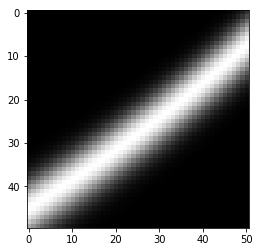

Score: 1.2962 -- Pitch: 53.5125508535, Yaw: 229.750258635, Horizontal FoV: 21.4138919377, Vertical FoV: 23.5638044039


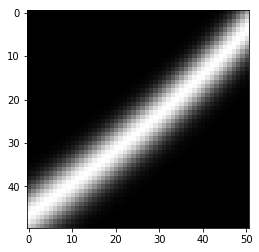

Score: 1.2749 -- Pitch: 60.9493814485, Yaw: 296.724181186, Horizontal FoV: 21.6276469635, Vertical FoV: 20.8867805961


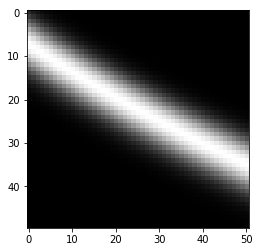

Score: 1.2709 -- Pitch: 58.7539992162, Yaw: 239.572386532, Horizontal FoV: 20.4372707337, Vertical FoV: 21.8978130573


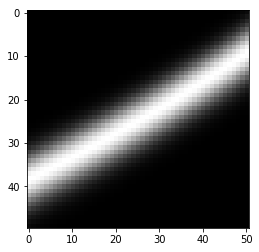

Score: 1.2694 -- Pitch: 56.0496902151, Yaw: 269.485921217, Horizontal FoV: 97.5508282335, Vertical FoV: 20.1625895717


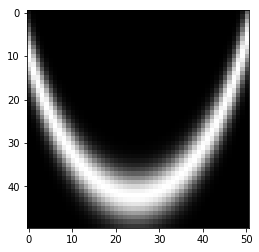

Score: 1.2670 -- Pitch: 49.9493451488, Yaw: 226.314871291, Horizontal FoV: 21.1815861835, Vertical FoV: 22.3162780976


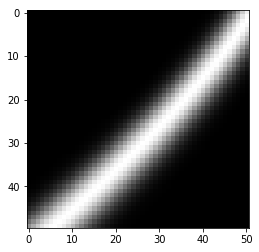

Score: 1.2190 -- Pitch: 57.0209656424, Yaw: 269.546843883, Horizontal FoV: 93.353614569, Vertical FoV: 20.9862636461


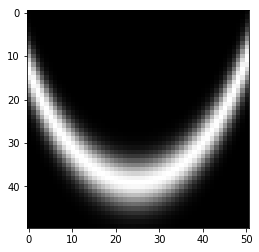

Score: 1.2178 -- Pitch: 57.2369859034, Yaw: 269.345236626, Horizontal FoV: 96.5182886984, Vertical FoV: 21.3003456906


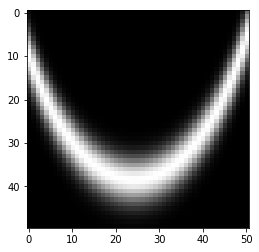

Score: 1.1966 -- Pitch: 56.2892436495, Yaw: 308.615045665, Horizontal FoV: 20.9161617505, Vertical FoV: 24.8003695855


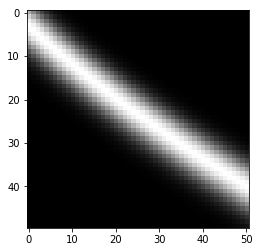

Score: 1.1850 -- Pitch: 56.7668500009, Yaw: 306.147127103, Horizontal FoV: 20.4162032115, Vertical FoV: 24.2112276804


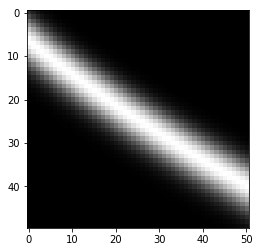

Score: 1.1485 -- Pitch: 51.5751086066, Yaw: 315.008927778, Horizontal FoV: 20.0360156381, Vertical FoV: 27.9732623433


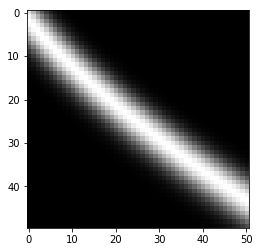

Score: 1.1398 -- Pitch: 63.1719762868, Yaw: 251.674017539, Horizontal FoV: 29.7219478766, Vertical FoV: 22.3406541158


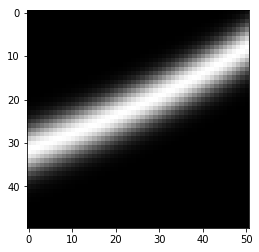

Score: 1.0634 -- Pitch: 59.912212697, Yaw: 299.801701189, Horizontal FoV: 22.7035290049, Vertical FoV: 25.5474584319


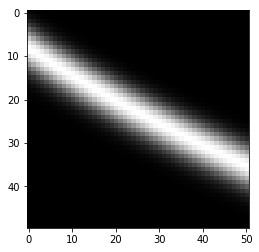

Score: 1.0574 -- Pitch: 56.1613549627, Yaw: 264.755884904, Horizontal FoV: 88.4127849037, Vertical FoV: 23.7911647486


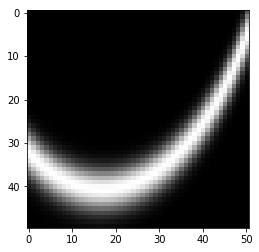

Score: 1.0212 -- Pitch: 51.4199358577, Yaw: 311.532106856, Horizontal FoV: 28.8817627179, Vertical FoV: 20.8443099684


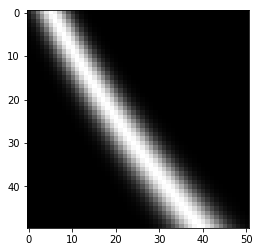

Score: 1.0174 -- Pitch: 55.9677821347, Yaw: 261.339010156, Horizontal FoV: 77.3117202877, Vertical FoV: 24.1001742937


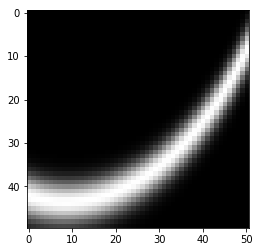

Score: 0.8121 -- Pitch: 45.7037630023, Yaw: 270.941321307, Horizontal FoV: 107.890276662, Vertical FoV: 36.8604382186


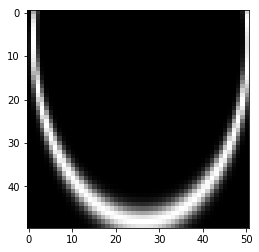

Score: 0.6953 -- Pitch: 68.6346225868, Yaw: 304.444773629, Horizontal FoV: 21.7862713244, Vertical FoV: 34.7582977536


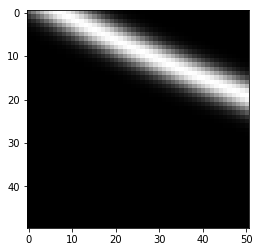

Score: 0.6198 -- Pitch: 43.3005073568, Yaw: 229.981632882, Horizontal FoV: 38.8988083114, Vertical FoV: 50.7255586481


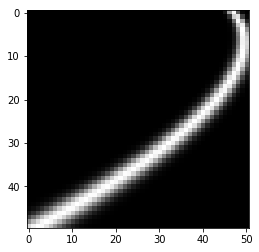

Score: 0.5355 -- Pitch: 43.0514480109, Yaw: 261.617323814, Horizontal FoV: 119.678082778, Vertical FoV: 50.1709810868


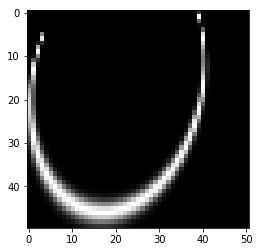

Score: 0.5126 -- Pitch: 37.0099427251, Yaw: 273.864704124, Horizontal FoV: 99.6883148079, Vertical FoV: 54.8801955533


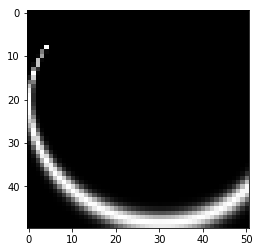

Score: 0.4981 -- Pitch: 47.5789672852, Yaw: 247.071882388, Horizontal FoV: 70.9192354947, Vertical FoV: 47.7620312123


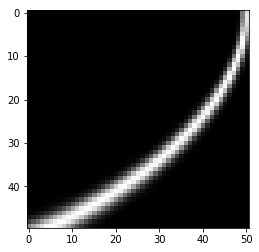

Score: 0.4612 -- Pitch: 33.7649915904, Yaw: 232.419096626, Horizontal FoV: 39.2775451628, Vertical FoV: 66.6027974764


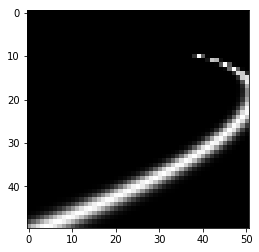

Score: 0.4541 -- Pitch: 35.3823198743, Yaw: 256.966104178, Horizontal FoV: 84.1761599564, Vertical FoV: 69.4215180338


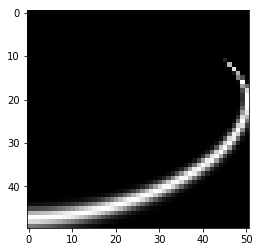

Score: 0.4429 -- Pitch: 38.0692053375, Yaw: 238.259180146, Horizontal FoV: 53.2809797784, Vertical FoV: 67.1553693674


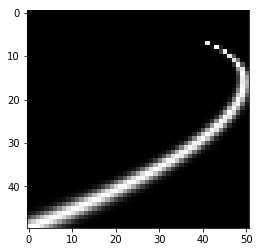

Score: 0.4159 -- Pitch: 81.4116020371, Yaw: 221.563513516, Horizontal FoV: 77.783054547, Vertical FoV: 23.8935804112


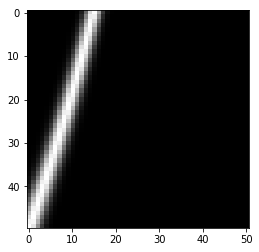

Score: 0.4047 -- Pitch: 36.1617506951, Yaw: 238.446872645, Horizontal FoV: 53.2044998241, Vertical FoV: 69.8522851057


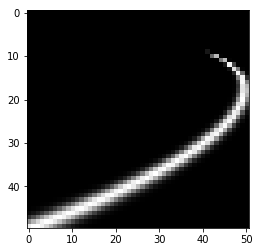

Score: 0.3563 -- Pitch: 78.4534908921, Yaw: 190.321269751, Horizontal FoV: 69.4555481902, Vertical FoV: 41.9497513291


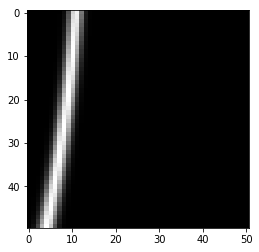

Score: 0.2618 -- Pitch: 83.6292835917, Yaw: 247.354893802, Horizontal FoV: 74.4867642722, Vertical FoV: 74.6320625432


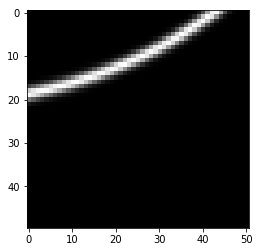

Score: 0.1276 -- Pitch: 43.7057859851, Yaw: 327.911357611, Horizontal FoV: 108.044547377, Vertical FoV: 110.558648486


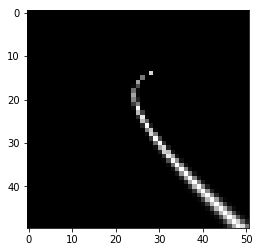

In [100]:
target_curvatures = [0.05]#, 0.2]
for i, curvature in enumerate(curvatures):
    if curvature not in target_curvatures:
        continue
    print("---- Curvature: {0} ----".format(curvature))

    scores, params = hillclimb_scores_params[i]
    scores, params = np.array(scores), np.array(params)
    sorted_indices = np.array(np.unravel_index(np.argsort(scores, axis=None), scores.shape)).T
    # print top 10 scores & display
    
    
    camera_height = 6.0
#     resolution = (125, 125) # use same resolution for all

    length = 2*np.pi/curvature # 1 full revolution
    path = Path()
    path.add_segment(curvature, length)
    road = Road(path=path, probability_distribution=road_prob_dist, width=3.0, side_offset=1.5)

    # place camera halfway along road
    allowed_positions_orientations = road.get_allowed_camera_positions_at_distance(length/2.0)
    lhs_pos, lhs_direction = allowed_positions_orientations[0]
    rhs_pos, rhs_direction = allowed_positions_orientations[1]
    
    camera_position = lhs_pos + np.array([0.0, 0.0, camera_height])
    print("Camera position: {0}".format(camera_position))

        # cylinder charactistics
    road_pt = road.path.get_point_at(length/2.0)
    road_normal = road.path.get_normal_at(length/2.0)
    road_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0))
    cylinder_radius = np.abs(1.0/road.path.get_curvature_at(length/2.0)) 
    cylinder_radius -= road.halfwidth 
    cylinder_radius -= road.side_offset
    cylinder_center = road_pt + road_normal * road_radius
    cylinder_direction = np.array([0.0, 0.0, 1.0])
    
    for index in sorted_indices[::-1][:]:
        pitch, yaw, h_fov, v_fov = params[index][0]
        score = scores[index]
        print("Score: {0:.4f} -- Pitch: {1}, Yaw: {2}, Horizontal FoV: {3}, Vertical FoV: {4}".format(float(scores[index]), pitch, yaw, h_fov, v_fov))

        c = Camera(camera_position, float(pitch), float(yaw))
        c.set_resolution(50, 50)
        c.set_fov(float(h_fov), float(v_fov))
        c.attach_cylinder(cylinder_center, cylinder_direction, cylinder_radius)
        pixel_probabilities = c.get_pixel_probabilities_for_road(road)
#         error_bounds = error_radius_across_pixels(c)
#         target = (1/(1+(error_bounds/3.0)**2)) * pixel_probabilities
#         score = np.sum(target)
#         print("Recomputed score with higher resolution: {0}".format(score))
        plt.imshow(np.flip(pixel_probabilities, 0))
        plt.gray()
        plt.show()

In [58]:
def score_function(params):
    pitch, yaw, h_fov, v_fov = params
    c = Camera(camera_position, pitch, yaw)
    c.set_resolution(*resolution)
    c.set_fov(h_fov, v_fov)

    error_bounds = error_radius_across_pixels(c)
    pixel_probabilities = c.get_pixel_probabilities_for_road(road)
    plt.imshow(np.flip(pixel_probabilities, 0))
    plt.gray()
    plt.show()
    target = (1/(1+(error_bounds/3.0)**2)) * pixel_probabilities
    score = np.sum(target)
    print("--score, params: {0}, {1}".format(score, params))
    return score

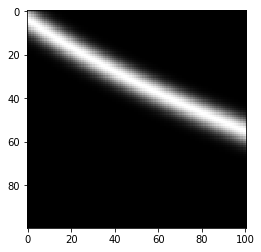

--score, params: 4.02559785934, [65.0, 305.0, 30.0, 44.0]


4.0255978593436668

In [76]:
score_function([65.0, 305.0, 30.0, 44.0])

In [55]:
camera_yaws

array([ 180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,  360.])